# Data Wrangling Project 

In [1]:
# read neccessary libraries
import pandas as pd
import numpy as np
import seaborn as sns
from scipy import stats
import matplotlib.pyplot as plt
plt.rc('figure', figsize=(20, 20))
%matplotlib inline
from dateutil.parser import parse
import datetime
import io
import re

from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [2]:
!pip install pandas==0.25

## Data Acquisition and Data Cleaning
The data needed for the analysis is first acquired. Then this data is cleaned so that the dataframes contain only data that is relevant to the project. Since for the project only a number of countries will be considered, data belonging to other countries is seen as irrelevant. 

In [3]:
# the list of countries (by name and code) that will be used for the project 
country_codes = ['KOR', 'USA', 'IND', 'ZAF', 'NLD', 'ESP']
country_names = ['South Korea', 'United States', 'India', 'South Africa', 'Netherlands', 'Spain']

In [4]:
# the gdp per capita in anual percentage per country 
df_gdp_pcap_all = pd.read_excel('/content/drive/Shareddrives/Data_Wraggling_Vu/data/gdp-pcap.xls', 'Data', header = 3)
df_gdp_pcap = df_gdp_pcap_all.loc[df_gdp_pcap_all['Country Code'].isin(country_codes)].dropna(axis = 1)
df_gdp_pcap['Country Name'] =  df_gdp_pcap['Country Name'].replace({'Korea, Rep.':'South Korea'})
display(df_gdp_pcap)

Country Name Country Code  ...          2019          2020
70           Spain          ESP  ...  42172.131705  38343.155224
109          India          IND  ...   6997.863988   6501.526071
126    South Korea          KOR  ...  42849.479080  43319.238299
176    Netherlands          NLD  ...  59675.180336  59334.214839
251  United States          USA  ...  65279.529026  63413.513858
263   South Africa          ZAF  ...  14289.760003  13355.598709

[6 rows x 35 columns]

In [5]:
# the division of religions per country
df_religions_all = pd.read_csv('/content/drive/Shareddrives/Data_Wraggling_Vu/data/religions.csv')
df_religions_per_pop = df_religions_all[df_religions_all['Country'].isin(country_names)]
df_religions_per_pop.head()

Year              Region  ...   Jews  All Religions
100  2010        Asia-Pacific  ...  10000     1224620000
152  2010              Europe  ...  30000       16610000
197  2010  Sub-Saharan Africa  ...  70000       50130000
198  2010        Asia-Pacific  ...  10000       48180000
199  2010              Europe  ...  60000       46080000

[5 rows x 12 columns]

In [6]:
# the type of political regime per country 
regime_types = {0: 'Closed Autocracy', 1: 'Electoral Autocracy', 2: 'Electoral Democracy', 3: 'Liberal Democracy'}
df_pr_all = pd.read_csv('/content/drive/Shareddrives/Data_Wraggling_Vu/data/political-regimes.csv').replace({'Political regime': regime_types})
df_political_regimes = df_pr_all[df_pr_all['Entity'].isin(country_names)]
df_political_regimes.head()

Entity Code  Year  Political regime
11997  India  IND  1789  Closed Autocracy
11998  India  IND  1790  Closed Autocracy
11999  India  IND  1791  Closed Autocracy
12000  India  IND  1792  Closed Autocracy
12001  India  IND  1793  Closed Autocracy

In [7]:
# the division of the population in age groups per country 
df_pop_all = pd.read_csv('/content/drive/Shareddrives/Data_Wraggling_Vu/data/population-by-broad-age-group.csv')
df_pop_all.columns = ['Entity', 'Code', 'Year', 'Population under age 5', 
                      'Population aged 5-14', 'Population aged 15-24', 'Population aged 25-64', 'Population aged 65 or over']
df_pop_per_age = df_pop_all[df_pop_all['Code'].isin(country_codes)]

# select only the year 2020
df_pop_2020 = df_pop_per_age[df_pop_per_age['Year'] == 2020].set_index('Entity').drop(columns=['Year', 'Code'])
df_pop_2020.head()


Population under age 5  ...  Population aged 65 or over
Entity                                ...                            
India                    116879507.0  ...                  90719952.0
Netherlands                 858900.0  ...                   3432942.0
South Africa               5764945.0  ...                   3267575.0
South Korea                1897011.0  ...                   8095870.0
Spain                      1990096.0  ...                   9340490.0

[5 rows x 5 columns]

In [8]:
data_film =  pd.read_csv("/content/drive/Shareddrives/Data_Wraggling_Vu/data/title_basic.tsv", sep='\t')
data =  pd.read_csv("/content/drive/Shareddrives/Data_Wraggling_Vu/data/title_akas.tsv", sep='\t')
data.head()

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (4,5) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


titleId  ordering  ...     attributes isOriginalTitle
0  tt0000001         1  ...             \N               0
1  tt0000001         2  ...  literal title               0
2  tt0000001         3  ...             \N               0
3  tt0000001         4  ...             \N               0
4  tt0000001         5  ...             \N               0

[5 rows x 8 columns]

## Data Merging and Data Aggregation


In [9]:
#aggelos-hidde

data = data.dropna()
data_film = data_film.loc[ data_film['titleType'] == 'movie']

data_film['genres'] = data_film['genres'].replace("\\N", np.nan)

data_film = data_film.dropna()

data_film.head()

tconst titleType  ... runtimeMinutes                      genres
570  tt0000574     movie  ...             70  Action,Adventure,Biography
587  tt0000591     movie  ...             90                       Drama
610  tt0000615     movie  ...             \N                       Drama
625  tt0000630     movie  ...             \N                       Drama
668  tt0000675     movie  ...             \N                       Drama

[5 rows x 9 columns]

In [10]:
#merging the movies per country based on the same title
data_US = data.loc[data['region'] == 'US']
us_final = data_US.merge(data_film, left_on=['title'], right_on=['primaryTitle'])

data_IND = data.loc[data['region'] == 'IN']
ind_final =  data_IND.merge(data_film, left_on=['title'], right_on=['primaryTitle'])

data_NL = data.loc[data['region'] == 'NL']
nl_final =  data_NL.merge(data_film, left_on=['title'], right_on=['primaryTitle'])

data_KOR = data.loc[data['region'] == 'KR']
kor_final =  data_KOR.merge(data_film, left_on=['title'], right_on=['primaryTitle'])

data_ZAF = data.loc[data['region'] == 'ZA']
zaf_final =  data_ZAF.merge(data_film, left_on=['title'], right_on=['primaryTitle'])

In [11]:
# removing duplicates and nan value and making a datetime index
updated_US = us_final

updated_US = updated_US[['startYear','title', 'genres', 'runtimeMinutes']]
updated_US = updated_US.drop_duplicates(subset=['title', 'startYear'], keep= 'first' )

updated_US['startYear'] = updated_US['startYear'].replace("\\N", np.nan)

updated_US = updated_US.dropna()

date_list = []
for x in updated_US['startYear']:
  date_list.append(pd.to_datetime(str(x), format='%Y'))
updated_US['startYear'] = date_list
updated_US = updated_US.sort_values('startYear')
updated_US = updated_US.set_index("startYear")

updated_US.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


title  ... runtimeMinutes
startYear                                                      ...               
1897-01-01  Reproduction of the Corbett and Fitzsimmons Fight  ...             \N
1898-01-01                    69th Regiment Passing in Review  ...             \N
1898-01-01                               Dressing Paper Dolls  ...             \N
1898-01-01                            Buck Dance, Ute Indians  ...             \N
1899-01-01           2nd Company Governor's Footguards, Conn.  ...             \N

[5 rows x 3 columns]

In [12]:

updated_IND = ind_final

updated_IND = updated_IND[['startYear','title', 'genres', 'runtimeMinutes']]
updated_IND = updated_IND.drop_duplicates(subset=['title', 'startYear'], keep= 'first' )

updated_IND['startYear'] = updated_IND['startYear'].replace("\\N", np.nan)


updated_IND = updated_IND.dropna()

date_list = []
for x in updated_IND['startYear']:
  date_list.append(pd.to_datetime(str(x), format='%Y'))
updated_IND['startYear'] = date_list
updated_IND = updated_IND.sort_values('startYear')

updated_IND = updated_IND.set_index("startYear")

updated_IND.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


title       genres runtimeMinutes
startYear                                        
1908-01-01   Scotland  Documentary             60
1908-01-01     Hamlet        Drama             \N
1910-01-01       Ibis  Documentary             \N
1910-01-01  Jane Eyre        Drama             \N
1910-01-01  The Abyss        Drama             90

### The top movie genres for each country in 2020

In [13]:
updated_NL = nl_final

updated_NL = updated_NL[['startYear','title', 'genres', 'runtimeMinutes']]
updated_NL = updated_NL.drop_duplicates(subset=['title', 'startYear'], keep= 'first' )

updated_NL['startYear'] = updated_NL['startYear'].replace("\\N", np.nan)



updated_NL = updated_NL.dropna()


date_list = []
for x in updated_NL['startYear']:
  date_list.append(pd.to_datetime(str(x), format='%Y'))
updated_NL['startYear'] = date_list
updated_NL = updated_NL.sort_values('startYear')

updated_NL= updated_NL.set_index("startYear")

updated_NL.head()

title       genres runtimeMinutes
startYear                                               
1907-01-01  The Prodigal Son        Drama             90
1908-01-01            Hamlet        Drama             \N
1909-01-01            België  Documentary             \N
1910-01-01         Jane Eyre        Drama             \N
1911-01-01    De bannelingen        Drama             50

In [14]:
updated_KOR = kor_final

updated_KOR = updated_KOR[['startYear','title', 'genres', 'runtimeMinutes']]
updated_KOR = updated_KOR.drop_duplicates(subset=['title', 'startYear'], keep= 'first' )

updated_KOR['startYear'] = updated_KOR['startYear'].replace("\\N", np.nan)


updated_KOR = updated_KOR.dropna()

date_list = []
for x in updated_KOR['startYear']:
  date_list.append(pd.to_datetime(str(x), format='%Y'))
updated_KOR['startYear'] = date_list
updated_KOR = updated_KOR.sort_values('startYear')

updated_KOR = updated_KOR.set_index("startYear")

updated_KOR.head()

title          genres runtimeMinutes
startYear                                                      
1911-01-01             Pinocchio         Fantasy             50
1912-01-01             Madeleine       Drama,War             46
1912-01-01                Strike  Drama,Thriller             \N
1913-01-01         Paradise Lost           Drama             \N
1913-01-01  Crime and Punishment           Drama             \N

In [15]:
updated_ZA = zaf_final

updated_ZA = updated_ZA[['startYear','title', 'genres', 'runtimeMinutes']]
updated_ZA = updated_ZA.drop_duplicates(subset=['title', 'startYear'], keep= 'first' )

updated_ZA['startYear'] = updated_ZA['startYear'].replace("\\N", np.nan)


updated_ZA = updated_ZA.dropna()


date_list = []
for x in updated_ZA['startYear']:
  date_list.append(pd.to_datetime(str(x), format='%Y'))
updated_ZA['startYear'] = date_list
updated_ZA = updated_ZA.sort_values('startYear')

updated_ZA = updated_ZA.set_index("startYear")

updated_ZA.head()

title       genres runtimeMinutes
startYear                                               
1907-01-01  The Prodigal Son        Drama             90
1911-01-01         Pinocchio      Fantasy             50
1913-01-01           Macbeth  Crime,Drama             50
1913-01-01          Atlantis        Drama            121
1914-01-01              Lola        Drama             \N

In [16]:
#method to add occurences of genre type
def get_oc(current_df):
    all_genres_list = [] 
    for x in current_df.genres:
        all_genres_list.extend(x.split(','))

    top_genres_df = pd.unique(all_genres_list)
    genres_Oc_df = pd.DataFrame(columns=['genre', 'Occurrence'])
    genres_Oc_df['genre'] = top_genres_df
    genres_Oc_df['Occurrence'] = 0

    for x in all_genres_list:
        genres_Oc_df.loc[genres_Oc_df['genre'] == x, 'Occurrence'] += 1

    return genres_Oc_df



def year_dataframe_ceate_add(origin_df, start_date, end_date):
    #init column names for genre
    init_year = str(start_date) + '-01-01'
    init_year_end = str(end_date) + '-12-31'

    init_df = origin_df[init_year:init_year_end]
    
    genres_Oc_df = get_oc(init_df)

    
    trans_df = genres_Oc_df.transpose()
    trans_df.columns = trans_df.iloc[0]
    trans_df = trans_df.drop('genre')
    trans_df = trans_df.reset_index(drop=True)
    trans_df["year"] = pd.to_datetime(str(start_date), format='%Y')
    trans_df = trans_df.set_index("year")

    start_date += 1
   
    temp_df = trans_df

    #adding all the other genres 
    for current_date in range(start_date, end_date):

        year_str =str(current_date) + '-01-01'
        year_end = str(current_date) + '-12-31'
        updated_init = origin_df[parse(year_str): parse(year_end)]


        all_init_genres = []
        for x in updated_init.genres:
            all_init_genres.extend(x.split(','))
        top_init_genres = pd.unique(all_init_genres)
      
        genres_init = pd.DataFrame(columns=['genre', 'Occurrence'])
        genres_init['genre'] = top_init_genres
        genres_init['Occurrence'] = 0
        
        for x in all_init_genres:
            genres_init.loc[genres_init['genre'] == x, 'Occurrence'] += 1

        new_topics = list()
        
        left_over = genres_init


        for y in trans_df.columns.tolist():
            value = genres_init.loc[genres_init['genre'] == y, 'Occurrence']
            if value.empty:
                new_topics.extend([0])
            else:
            
                new_topics.extend(value)
                genres_init = genres_init.drop(genres_init.loc[genres_init['genre'] == y].index)
            left_over = genres_init



        temp_df.loc[datetime.datetime.strptime(year_str, '%Y-%m-%d')] = new_topics

    return temp_df
    



In [17]:
#creating the genre tables per country
US = year_dataframe_ceate_add(updated_US, 1990, 2020)
IND = year_dataframe_ceate_add(updated_IND, 1990, 2020)
NL = year_dataframe_ceate_add(updated_NL, 1990, 2020)
KRS = year_dataframe_ceate_add(updated_KOR, 1990, 2020)
ZA = year_dataframe_ceate_add(updated_ZA, 1990, 2020)


In [18]:
# USA
US.head()

genre      Adult  Drama Action Adventure  ... Short Reality-TV Talk-Show Game-Show
year                                      ...                                     
1990-01-01  1411  57940  13653      7211  ...    30        132        69         7
1991-01-01    90    580    236        74  ...     0          0         0         0
1992-01-01    84    569    233        63  ...     0          0         0         0
1993-01-01    51    610    244        67  ...     0          0         0         0
1994-01-01    44    659    254        95  ...     1          0         0         0

[5 rows x 27 columns]

In [19]:
#South Korea
KRS.head()

genre      Drama Comedy Romance Action  ... News Talk-Show Game-Show Short
year                                    ...                               
1990-01-01  3175    882     789    603  ...   19         1         2     1
1991-01-01    41      9       9     10  ...    0         0         0     0
1992-01-01    42     13      11     16  ...    0         0         0     0
1993-01-01    37     18      13     12  ...    0         0         0     0
1994-01-01    35     12      15      8  ...    0         0         0     0

[5 rows x 27 columns]

### Dataframes per country

In [20]:
#Spain Dataframe
SP_df = df_gdp_pcap.loc[df_gdp_pcap['Country Name'] == 'United States']
SP_df = SP_df.drop(columns=SP_df.columns[1:3])

SP_df = SP_df.melt(id_vars=['Country Name'],var_name='Year',value_name='GDP')

SP_df['Year'] = SP_df['Year'].astype(str)
df_political_regimes['Year'] = df_political_regimes['Year'].astype(str)
df_religions_per_pop['Year'] = df_religions_per_pop['Year'].astype(str)
df_pop_per_age['Year'] = df_pop_per_age['Year'].astype(str)
SP_df = SP_df.merge(df_political_regimes, left_on=['Year','Country Name'], right_on=['Year','Entity'])
SP_df = SP_df.merge(df_religions_per_pop, left_on=['Country Name','Year'], right_on=['Country','Year'],how='left')
SP_df = SP_df.fillna(method ='bfill')
SP_df = SP_df.merge(df_pop_per_age, left_on=['Entity','Year'], right_on=['Entity','Year'])
SP_df = SP_df.drop(columns=['Entity','Code_x','Code_y',])
SP_df.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.

Country Name  Year  ...  Population aged 25-64 Population aged 65 or over
0  United States  1990  ...            128244658.0                 31837211.0
1  United States  1991  ...            129871925.0                 32255055.0
2  United States  1992  ...            131489917.0                 32627760.0
3  United States  1993  ...            133126275.0                 32968977.0
4  United States  1994  ...            134852459.0                 33284733.0

[5 rows x 20 columns]

In [21]:
# USA Dataframe
USA_df = df_gdp_pcap.loc[df_gdp_pcap['Country Name'] == 'United States']
USA_df = USA_df.drop(columns=USA_df.columns[1:3])

USA_df = USA_df.melt(id_vars=['Country Name'],var_name='Year',value_name='GDP')

USA_df['Year'] = USA_df['Year'].astype(str)
df_political_regimes['Year'] = df_political_regimes['Year'].astype(str)
df_religions_per_pop['Year'] = df_religions_per_pop['Year'].astype(str)
df_pop_per_age['Year'] = df_pop_per_age['Year'].astype(str)
USA_df = USA_df.merge(df_political_regimes, left_on=['Year','Country Name'], right_on=['Year','Entity'])
USA_df = USA_df.merge(df_religions_per_pop, left_on=['Country Name','Year'], right_on=['Country','Year'],how='left')
USA_df = USA_df.fillna(method ='bfill')
USA_df = USA_df.merge(df_pop_per_age, left_on=['Entity','Year'], right_on=['Entity','Year'])
USA_df = USA_df.drop(columns=['Entity','Code_x','Code_y',])
USA_df.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.

Country Name  Year  ...  Population aged 25-64 Population aged 65 or over
0  United States  1990  ...            128244658.0                 31837211.0
1  United States  1991  ...            129871925.0                 32255055.0
2  United States  1992  ...            131489917.0                 32627760.0
3  United States  1993  ...            133126275.0                 32968977.0
4  United States  1994  ...            134852459.0                 33284733.0

[5 rows x 20 columns]

In [22]:
# India Dataframe
IND_df = df_gdp_pcap.loc[df_gdp_pcap['Country Name'] == 'India']
IND_df = IND_df.drop(columns=IND_df.columns[1:3])

IND_df = IND_df.melt(id_vars=['Country Name'],var_name='Year',value_name='GDP')

IND_df['Year'] = IND_df['Year'].astype(str)
df_political_regimes['Year'] = df_political_regimes['Year'].astype(str)
df_religions_per_pop['Year'] = df_religions_per_pop['Year'].astype(str)
df_pop_per_age['Year'] = df_pop_per_age['Year'].astype(str)
IND_df = IND_df.merge(df_political_regimes, left_on=['Year','Country Name'], right_on=['Year','Entity'])
IND_df = IND_df.merge(df_religions_per_pop, left_on=['Country Name','Year'], right_on=['Country','Year'],how='left')
IND_df = IND_df.fillna(method ='bfill')
IND_df = IND_df.merge(df_pop_per_age, left_on=['Entity','Year'], right_on=['Entity','Year'])
IND_df = IND_df.drop(columns=['Entity','Code_x','Code_y'])
IND_df.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.

Country Name  Year  ...  Population aged 25-64 Population aged 65 or over
0        India  1990  ...            342050169.0                 33223204.0
1        India  1991  ...            350556433.0                 34406324.0
2        India  1992  ...            359310836.0                 35553227.0
3        India  1993  ...            368354271.0                 36671638.0
4        India  1994  ...            377761853.0                 37776067.0

[5 rows x 20 columns]

In [23]:
# Netherlands Dataframe
NL_df = df_gdp_pcap.loc[df_gdp_pcap['Country Name'] == 'Netherlands']
NL_df = NL_df.drop(columns=NL_df.columns[1:3])

NL_df = NL_df.melt(id_vars=['Country Name'],var_name='Year',value_name='GDP')

NL_df['Year'] = NL_df['Year'].astype(str)
df_political_regimes['Year'] = df_political_regimes['Year'].astype(str)
df_religions_per_pop['Year'] = df_religions_per_pop['Year'].astype(str)
df_pop_per_age['Year'] = df_pop_per_age['Year'].astype(str)
NL_df = NL_df.merge(df_political_regimes, left_on=['Year','Country Name'], right_on=['Year','Entity'])
NL_df = NL_df.merge(df_religions_per_pop, left_on=['Country Name','Year'], right_on=['Country','Year'],how='left')
NL_df = NL_df.fillna(method ='bfill')
NL_df = NL_df.merge(df_pop_per_age, left_on=['Entity','Year'], right_on=['Entity','Year'])

NL_df = NL_df.drop(columns=['Entity','Code_x','Code_y',])
NL_df.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.

Country Name  Year  ...  Population aged 25-64 Population aged 65 or over
0  Netherlands  1990  ...              7998521.0                  1904823.0
1  Netherlands  1991  ...              8111880.0                  1934590.0
2  Netherlands  1992  ...              8229284.0                  1960357.0
3  Netherlands  1993  ...              8346739.0                  1983542.0
4  Netherlands  1994  ...              8459653.0                  2006479.0

[5 rows x 20 columns]

In [24]:
# South Africa Dataframe
ZA_df = df_gdp_pcap.loc[df_gdp_pcap['Country Name'] == 'South Africa']
ZA_df = ZA_df.drop(columns=ZA_df.columns[1:3])

ZA_df = ZA_df.melt(id_vars=['Country Name'],var_name='Year',value_name='GDP')

ZA_df['Year'] =ZA_df['Year'].astype(str)
df_political_regimes['Year'] = df_political_regimes['Year'].astype(str)
df_religions_per_pop['Year'] = df_religions_per_pop['Year'].astype(str)
df_pop_per_age['Year'] = df_pop_per_age['Year'].astype(str)
ZA_df = ZA_df.merge(df_political_regimes, left_on=['Year','Country Name'], right_on=['Year','Entity'])
ZA_df = ZA_df.merge(df_religions_per_pop, left_on=['Country Name','Year'], right_on=['Country','Year'],how='left')
ZA_df = ZA_df.fillna(method ='bfill')
ZA_df = ZA_df.merge(df_pop_per_age, left_on=['Entity','Year'], right_on=['Entity','Year'])
ZA_df = ZA_df.drop(columns=['Entity','Code_x','Code_y'])
ZA_df.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.

Country Name  Year  ...  Population aged 25-64 Population aged 65 or over
0  South Africa  1990  ...             13504803.0                  1459812.0
1  South Africa  1991  ...             13963700.0                  1515714.0
2  South Africa  1992  ...             14461647.0                  1576998.0
3  South Africa  1993  ...             14988284.0                  1642941.0
4  South Africa  1994  ...             15528956.0                  1712173.0

[5 rows x 20 columns]

In [25]:
# South Korea Dataframe
KOR_df = df_gdp_pcap.loc[df_gdp_pcap['Country Name'] == 'South Korea']
KOR_df = KOR_df.drop(columns=KOR_df.columns[1:3])

KOR_df = KOR_df.melt(id_vars=['Country Name'],var_name='Year',value_name='GDP')

KOR_df['Year'] = KOR_df['Year'].astype(str)
df_political_regimes['Year'] = df_political_regimes['Year'].astype(str)
df_religions_per_pop['Year'] = df_religions_per_pop['Year'].astype(str)
df_pop_per_age['Year'] = df_pop_per_age['Year'].astype(str)
KOR_df = KOR_df.merge(df_political_regimes, left_on=['Year','Country Name'], right_on=['Year','Entity'])
KOR_df = KOR_df.merge(df_religions_per_pop, left_on=['Country Name','Year'], right_on=['Country','Year'],how='left')
KOR_df = KOR_df.fillna(method ='bfill')
KOR_df = KOR_df.merge(df_pop_per_age, left_on=['Entity','Year'], right_on=['Entity','Year'])
KOR_df = KOR_df.drop(columns=['Entity','Code_x','Code_y'])
KOR_df.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.

Country Name  Year  ...  Population aged 25-64 Population aged 65 or over
0  South Korea  1990  ...             20894710.0                  2245921.0
1  South Korea  1991  ...             21528250.0                  2342897.0
2  South Korea  1992  ...             22093976.0                  2427972.0
3  South Korea  1993  ...             22620492.0                  2509354.0
4  South Korea  1994  ...             23161692.0                  2600172.0

[5 rows x 20 columns]

In [26]:
#dataframe for gdp vs genre per country
def add_col(frame_df, col):
  gdp_list = []

  for x in col['GDP']:
    gdp_list.append(x)

  gdp_list = gdp_list[:-1]
  frame_df['GDP'] = gdp_list

  return frame_df

IND_GDP = add_col(IND[['Drama', "Action", "War", "Family", "Horror", 'News']], IND_df[['Year', 'GDP']])
IND_GDP = IND_GDP.iloc[1:, :]

KOR_GDP = add_col(KRS[['Drama', "Action", "War", "Family", "Horror", 'News']], KOR_df[['Year', 'GDP']])
KOR_GDP = KOR_GDP.iloc[1:, :]

NL_GDP = add_col(NL[['Drama', "Action", "War", "Family", "Horror", 'News']], NL_df[['Year', 'GDP']])
NL_GDP = NL_GDP.iloc[1:, :]

ZA_GDP = add_col(ZA[['Drama', "Action", "War", "Family", "Horror", 'News']], ZA_df[['Year', 'GDP']])
ZA_GDP = ZA_GDP.iloc[1:, :]

US_GDP = add_col(US[['Drama', "Action", "War", 'Family', "Horror", 'News']], USA_df[['Year', 'GDP']])
US_GDP = US_GDP.iloc[1:, :]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


In [27]:
#dataframe for religion vs genre per country
def add_col_MUL(complete, col, text):
  A_list = []
  B_list = []

  for x in col[text]:
    A_list.append(x)

  for x in col['Unaffiliated']:
    B_list.append(x)


  A_list = A_list[:-1]
  complete['Religion'] = A_list

  B_list = B_list[:-1]
  complete['NON_REL'] = B_list

  return complete


IND_REL = add_col_MUL(IND[['Documentary', "Action", "War", "Family", "Horror", 'News', "Comedy", "Fantasy"]], IND_df[['Unaffiliated', 'Hindus']], 'Hindus')
IND_REL = IND_REL.iloc[1:, :]

KOR_REL = add_col_MUL(KRS[['Documentary', "Action", "War", "Family", "Horror", 'News', "Comedy", "Fantasy"]], KOR_df[['Unaffiliated', 'Christians']], 'Christians')
KOR_REL = KOR_REL.iloc[1:, :]

NL_REL = add_col_MUL(NL[['Documentary', "Action", "War", "Family", "Horror", 'News', "Comedy", "Fantasy"]], NL_df[['Unaffiliated', 'Christians']], 'Christians')
NL_REL = NL_REL.iloc[1:, :]

ZA_REL = add_col_MUL(ZA[['Documentary', "Action", "War", "Family", "Horror", 'News', "Comedy", "Fantasy"]], ZA_df[['Unaffiliated', 'Christians']], 'Christians')
ZA_REL = ZA_REL.iloc[1:, :]

US_REL = add_col_MUL(US[['Documentary', "Action", "War", "Family", "Horror", 'News', "Comedy", "Fantasy"]], USA_df[['Unaffiliated', 'Christians']], 'Christians')
US_REL = US_REL.iloc[1:, :]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [28]:
#dataframe for age population vs genre per country
def add_col_MUL_MUL(complete, col):
  A_list = []
  B_list = []
  C_list = []

  for x in col['Population aged 5-14']:
    A_list.append(x)

  for x in col['Population aged 25-64']:
    B_list.append(x)
  
  for x in col['Population aged 65 or over']:
    C_list.append(x)


  A_list = A_list[:-1]
  complete['Population aged 5-14'] = A_list

  B_list = B_list[:-1]
  complete['Population aged 25-64'] = B_list

  C_list = C_list[:-1]
  complete['Population aged 65 or over'] = C_list

  return complete


IND_POP = add_col_MUL_MUL(IND[['Documentary', "History", "War", "Family", "Horror", 'Adult', "Comedy", "Fantasy"]], IND_df[['Population aged 5-14', 'Population aged 25-64','Population aged 65 or over']])
IND_POP = IND_POP.iloc[1:, :]

KOR_POP = add_col_MUL_MUL(KRS[['Documentary', "History", "War", "Family", "Horror", 'Adult', "Comedy", "Fantasy"]], KOR_df[['Population aged 5-14', 'Population aged 25-64','Population aged 65 or over']])
KOR_POP = KOR_POP.iloc[1:, :]

NL_POP = add_col_MUL_MUL(NL[['Documentary', "History", "War", "Family", "Horror", 'Adult', "Comedy", "Fantasy"]], NL_df[['Population aged 5-14', 'Population aged 25-64','Population aged 65 or over']])
NL_POP = NL_POP.iloc[1:, :]

ZA_POP = add_col_MUL_MUL(ZA[['Documentary', "History", "War", "Family", "Horror", 'Adult', "Comedy", "Fantasy"]], ZA_df[['Population aged 5-14', 'Population aged 25-64','Population aged 65 or over']])
ZA_POP = ZA_POP.iloc[1:, :]

US_POP = add_col_MUL_MUL(US[['Documentary', "History", "War", "Family", "Horror", 'Adult', "Comedy", "Fantasy"]], USA_df[['Population aged 5-14', 'Population aged 25-64','Population aged 65 or over']])
US_POP = US_POP.iloc[1:, :]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/

In [29]:
#dataframe for goverment type vs genre per country
pie_year_A = '1991-01-01'
pie_year_A_end = '1991-12-31'
pie_year_B = '2000-01-01'
pie_year_B_end = '2000-12-31'
pie_year_C = '2019-01-01'
pie_year_C_end = '2019-12-31'


IND_GOVA = IND[pie_year_A:pie_year_A_end]
IND_GOVB = IND[pie_year_B:pie_year_B_end]
IND_GOVC = IND[pie_year_C:pie_year_C_end]

NL_GOVA = NL[pie_year_A:pie_year_A_end]
NL_GOVB = NL[pie_year_B:pie_year_B_end]
NL_GOVC = NL[pie_year_C:pie_year_C_end]

KOR_GOVA = KRS[pie_year_A:pie_year_A_end]
KOR_GOVB = KRS[pie_year_B:pie_year_B_end]
KOR_GOVC = KRS[pie_year_C:pie_year_C_end]


ZA_GOVA = ZA[pie_year_A:pie_year_A_end]
ZA_GOVB = ZA[pie_year_B:pie_year_B_end]
ZA_GOVC = ZA[pie_year_C:pie_year_C_end]

US_GOVA = US[pie_year_A:pie_year_A_end]
US_GOVB = US[pie_year_B:pie_year_B_end]
US_GOVC = US[pie_year_C:pie_year_C_end]



**Netflix data/country ~2021**:

In [30]:

pd.options.display.max_rows = 65
np.set_printoptions(precision = 4, suppress = True)


dataNetflix = pd.read_csv('/content/drive/Shareddrives/Data_Wraggling_Vu/data/netflix_countries.csv') #Source: Kaggle


#Only season_title has NaN-values. #Drop irrelevant Columns
dataNetflix.isna().sum()
dataNetflix = dataNetflix.drop(columns= ['season_title','week','weekly_rank'])


#Select only Movies from data
dataNetflix = dataNetflix.groupby('category')
dataNetflixMovies = dataNetflix.get_group('Films')


#Renaming the column
dataNetflixMovies = dataNetflixMovies.rename(columns={'country_iso2':'country_code'})

# #Sort country in alphabetical order and sort most popular Movie by cumulative weeks in top10
dataNetflixMovies = dataNetflixMovies.sort_values(by=['country_name','cumulative_weeks_in_top_10'],
                                                              ascending=[True, False])

#Replace same movie with different name
dataNetflixMovies['show_title'] = dataNetflixMovies['show_title'].replace({"SAS: Rise of the Black Swan":"Red Notice"})

#Selecting only the desired countries (code) for further wrangling &
#Drop duplicate show titles & Adjust index in ranking order
dataMovieCountry = dataNetflixMovies.groupby('country_code')
movieUSA  = dataMovieCountry.get_group('US').drop_duplicates('show_title')
movieUSA.reset_index(inplace=True, drop=True)

movieKOR = dataMovieCountry.get_group('KR').drop_duplicates('show_title')
movieKOR.reset_index(inplace=True, drop=True)

movieIND = dataMovieCountry.get_group('IN').drop_duplicates('show_title')
movieIND.reset_index(inplace=True, drop=True)

movieZAF = dataMovieCountry.get_group('ZA').drop_duplicates('show_title')
movieZAF.reset_index(inplace=True, drop=True)

movieNLD = dataMovieCountry.get_group('NL').drop_duplicates('show_title')
movieNLD.reset_index(inplace=True, drop=True)

movieESP = dataMovieCountry.get_group('ES').drop_duplicates('show_title')
movieESP.reset_index(inplace=True, drop=True)


#Concatenating the dataframes of the different countries into one.
countriesFrame = [movieUSA, movieKOR, movieIND, movieZAF, movieNLD, movieESP]
selectedCountriesMovies = pd.concat(countriesFrame)
# selectedCountriesMovies

#Replace the elements of country code
selectedCountriesMovies['country_code'] = selectedCountriesMovies['country_code'].replace(
    {'US':'USA', 'KR':'KOR', 'IN':'IND', 'ZA':'ZAF', 'NL':'NLD', 'ES':'ESP'}
)

#Naming Index
selectedCountriesMovies.index.name = 'rank'


#Selectig only the top5 of each country
top10 = [0,1,2,3,4,5,6,7,8,9]
selectedCountriesMovies = selectedCountriesMovies.loc[top10]


selectedCountriesMovies.sort_values(by=['country_name','rank'], ascending=[True, True], inplace=True)

selectedCountriesMovies

# selectedCountriesMovies = selectedCountriesMovies.groupby(by='country_code')
# selectedCountriesMovies.get_group('ZAF')



country_name  ... cumulative_weeks_in_top_10
rank                 ...                           
0             India  ...                         17
1             India  ...                         14
2             India  ...                         10
3             India  ...                          9
4             India  ...                          7
5             India  ...                          7
6             India  ...                          6
7             India  ...                          6
8             India  ...                          6
9             India  ...                          5
0       Netherlands  ...                          6
1       Netherlands  ...                          5
2       Netherlands  ...                          5
3       Netherlands  ...                          4
4       Netherlands  ...                          4
5       Netherlands  ...                          4
6       Netherlands  ...                          4
7       Netherlands  ...                          4
8       Netherlands  ...                          4
9       Netherlands  ...                          4
0      South Africa  ...                          8
1      South Africa  ...                          4
2      South Africa  ...                          4
3      South Africa  ...                          4
4      South Africa  ...                          4
5      South Africa  ...                          4
6      South Africa  ...                          4
7      South Africa  ...                          4
8      South Africa  ...                          3
9      South Africa  ...                          3
0       South Korea  ...                         12
1       South Korea  ...                         11
2       South Korea  ...                          9
3       South Korea  ...                          5
4       South Korea  ...                          5
5       South Korea  ...                          5
6       South Korea  ...                          5
7       South Korea  ...                          5
8       South Korea  ...                          4
9       South Korea  ...                          4
0             Spain  ...                          6
1             Spain  ...                          5
2             Spain  ...                          5
3             Spain  ...                          4
4             Spain  ...                          4
5             Spain  ...                          4
6             Spain  ...                          4
7             Spain  ...                          4
8             Spain  ...                          4
9             Spain  ...                          4
0     United States  ...                          9
1     United States  ...                          8
2     United States  ...                          6
3     United States  ...                          5
4     United States  ...                          5
5     United States  ...                          4
6     United States  ...                          4
7     United States  ...                          4
8     United States  ...                          4
9     United States  ...                          4

[60 rows x 5 columns]

Top 10 of each country:

In [31]:
data_film['genres'] = data_film['genres'].str.replace("\\\\N", '')

#Merging
final_selectedCountriesMovies = selectedCountriesMovies.reset_index().merge(
    data_film, left_on='show_title', right_on= 'primaryTitle', how= 'left' ).set_index('rank')

#Adjust ranking
final_selectedCountriesMovies.index = final_selectedCountriesMovies.index + 1

final_selectedCountriesMovies = final_selectedCountriesMovies.drop_duplicates(
    subset=['show_title', 'country_code'], keep= 'last' )

final_selectedCountriesMovies = final_selectedCountriesMovies[['country_name', 'country_code', 'show_title', 'genres']]

final_selectedCountriesMovies.reset_index(inplace=True, drop=False)

#Add cell value to NaN
final_selectedCountriesMovies.at[30,'genres'] = "Action,Drama,History"
final_selectedCountriesMovies.at[33,'genres'] = "Action,Drama"
final_selectedCountriesMovies.at[44,'genres'] = "Comedy"
final_selectedCountriesMovies.at[6,'genres'] = "Drama"
final_selectedCountriesMovies.at[35,'genres'] = "Action,Animation,Fantasy"
final_selectedCountriesMovies.at[36,'genres'] = "Action,Crime"
final_selectedCountriesMovies.at[49,'genres'] = "Horror,Mystery"


final_selectedCountriesMovies.head()

rank country_name  ...              show_title                  genres
0     1        India  ...         Haseen Dillruba     Crime,Drama,Mystery
1     2        India  ...                    Mimi                   Drama
2     3        India  ...              Red Notice  Action,Comedy,Thriller
3     4        India  ...  Meenakshi Sundareshwar          Comedy,Romance
4     5        India  ...            Sooryavanshi   Action,Crime,Thriller

[5 rows x 5 columns]

Count genres of top10/country:

In [32]:
#Count genres
final_selectedCountriesMovies['genres'] = final_selectedCountriesMovies['genres'].str.split(',')

final_selectedCountriesMovies = final_selectedCountriesMovies.explode('genres').reset_index(drop=True)


totalGenreCountry = final_selectedCountriesMovies.groupby(['country_name', 'genres']).size()

totalGenreCountry = totalGenreCountry.to_frame()

totalGenreCountry = totalGenreCountry.rename(columns={0:'total'})
totalGenreCountry.head()

total
country_name genres          
India        Action         4
             Adventure      2
             Comedy         3
             Crime          2
             Drama          4

## Data Visualization 

In [33]:
# all images are saved to a special directory 
images_dir = '/content/drive/Shareddrives/Data_Wraggling_Vu/images'

In [34]:
# the color palette used for the data visualization 
colors = sns.color_palette('YlGnBu_r')

Plot Genre Vs Time

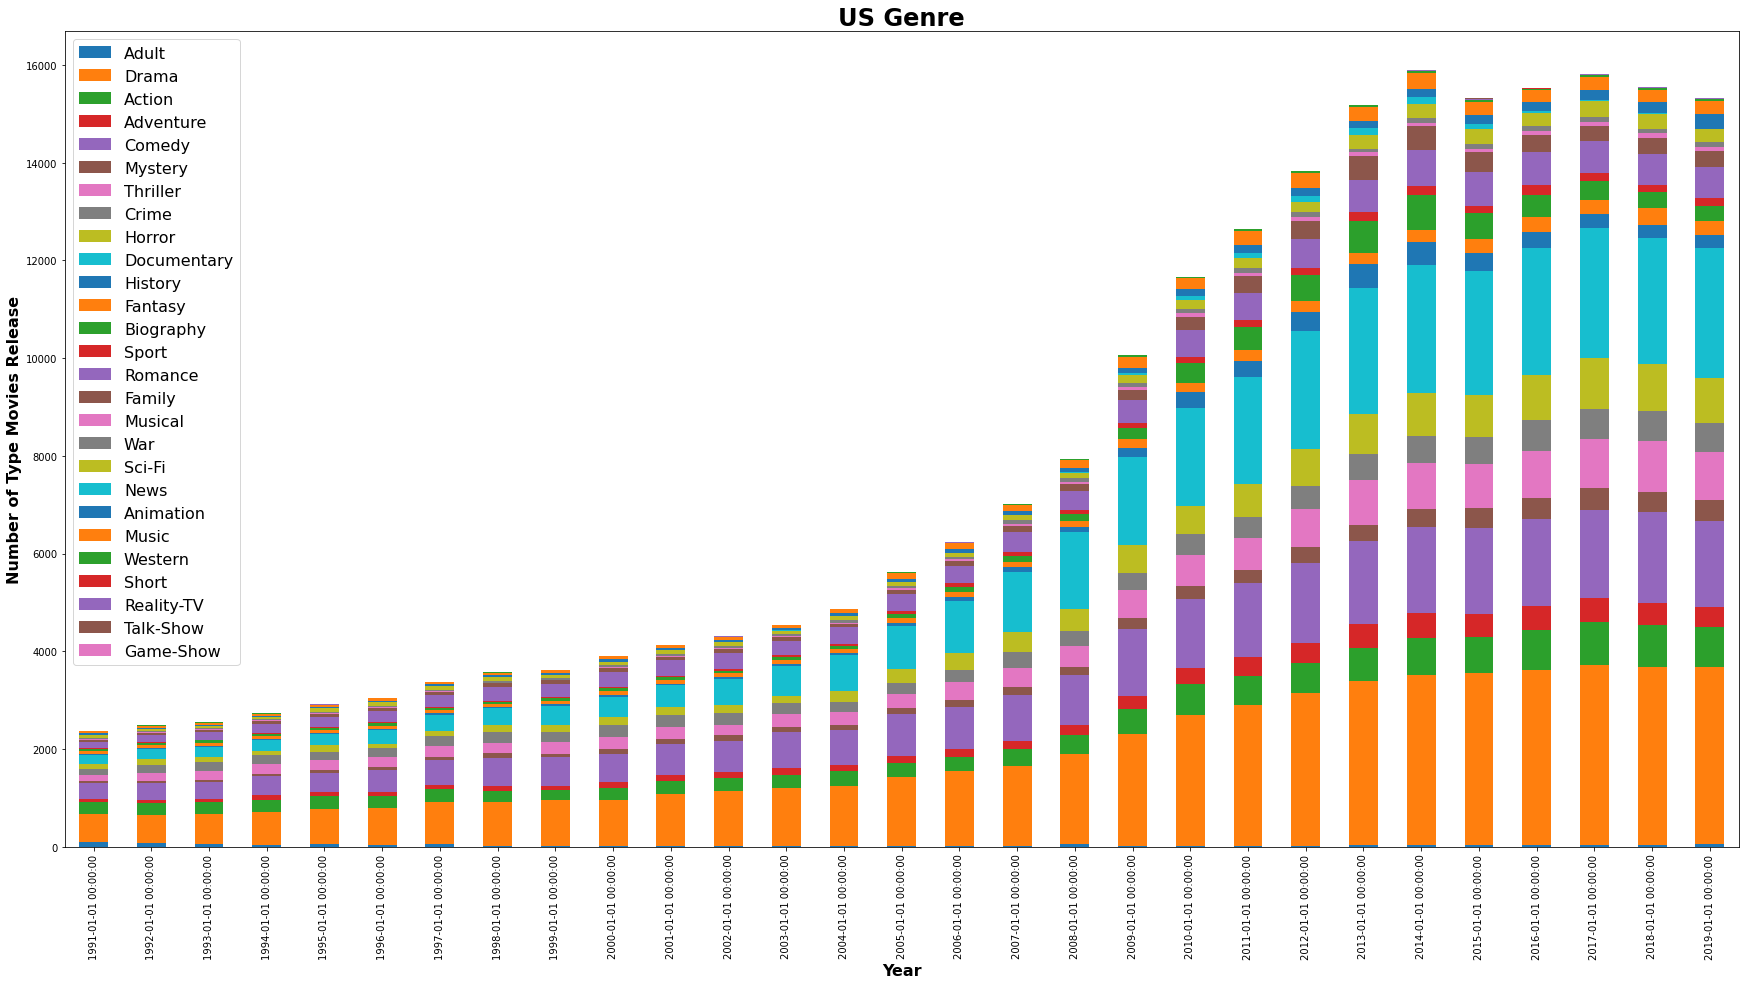

In [35]:

temp_US = US.iloc[1:, :]

gdp_plot =temp_US.plot.bar(stacked=True, figsize = (30, 15))
gdp_plot.set_title('US Genre', fontsize=24, fontweight='bold')
gdp_plot.set_xlabel('Year', fontsize=16, fontweight='bold')
gdp_plot.set_ylabel('Number of Type Movies Release', fontsize=16, fontweight='bold')
gdp_plot.legend(loc='best', prop={'size':16})

gdp_plot.figure.savefig(f"{images_dir}/US_genre_time.png", dpi=400, bbox_inches='tight')

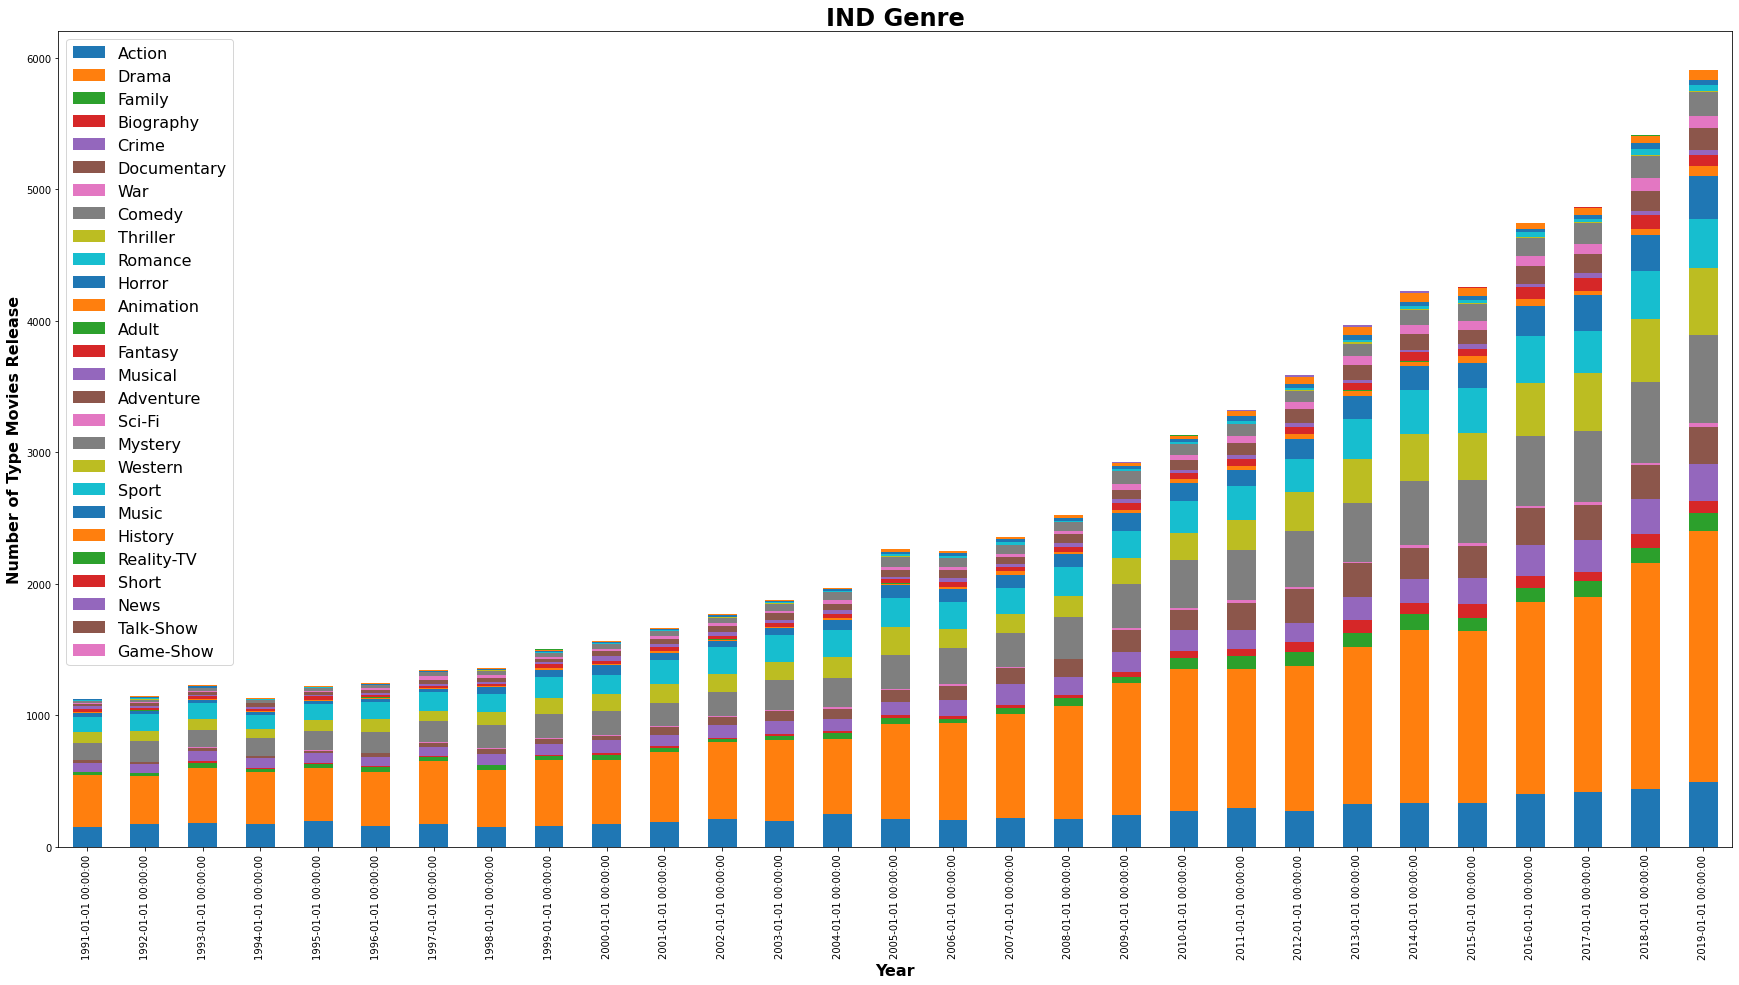

In [36]:
temp_IND = IND.iloc[1:, :]

gdp_plot =temp_IND.plot.bar(stacked=True, figsize = (30, 15))
gdp_plot.set_title('IND Genre', fontsize=24, fontweight='bold')
gdp_plot.set_xlabel('Year', fontsize=16, fontweight='bold')
gdp_plot.set_ylabel('Number of Type Movies Release', fontsize=16, fontweight='bold')
gdp_plot.legend(loc='best', prop={'size':16})

gdp_plot.figure.savefig(f"{images_dir}/IND_genre_time.png", dpi=400, bbox_inches='tight')

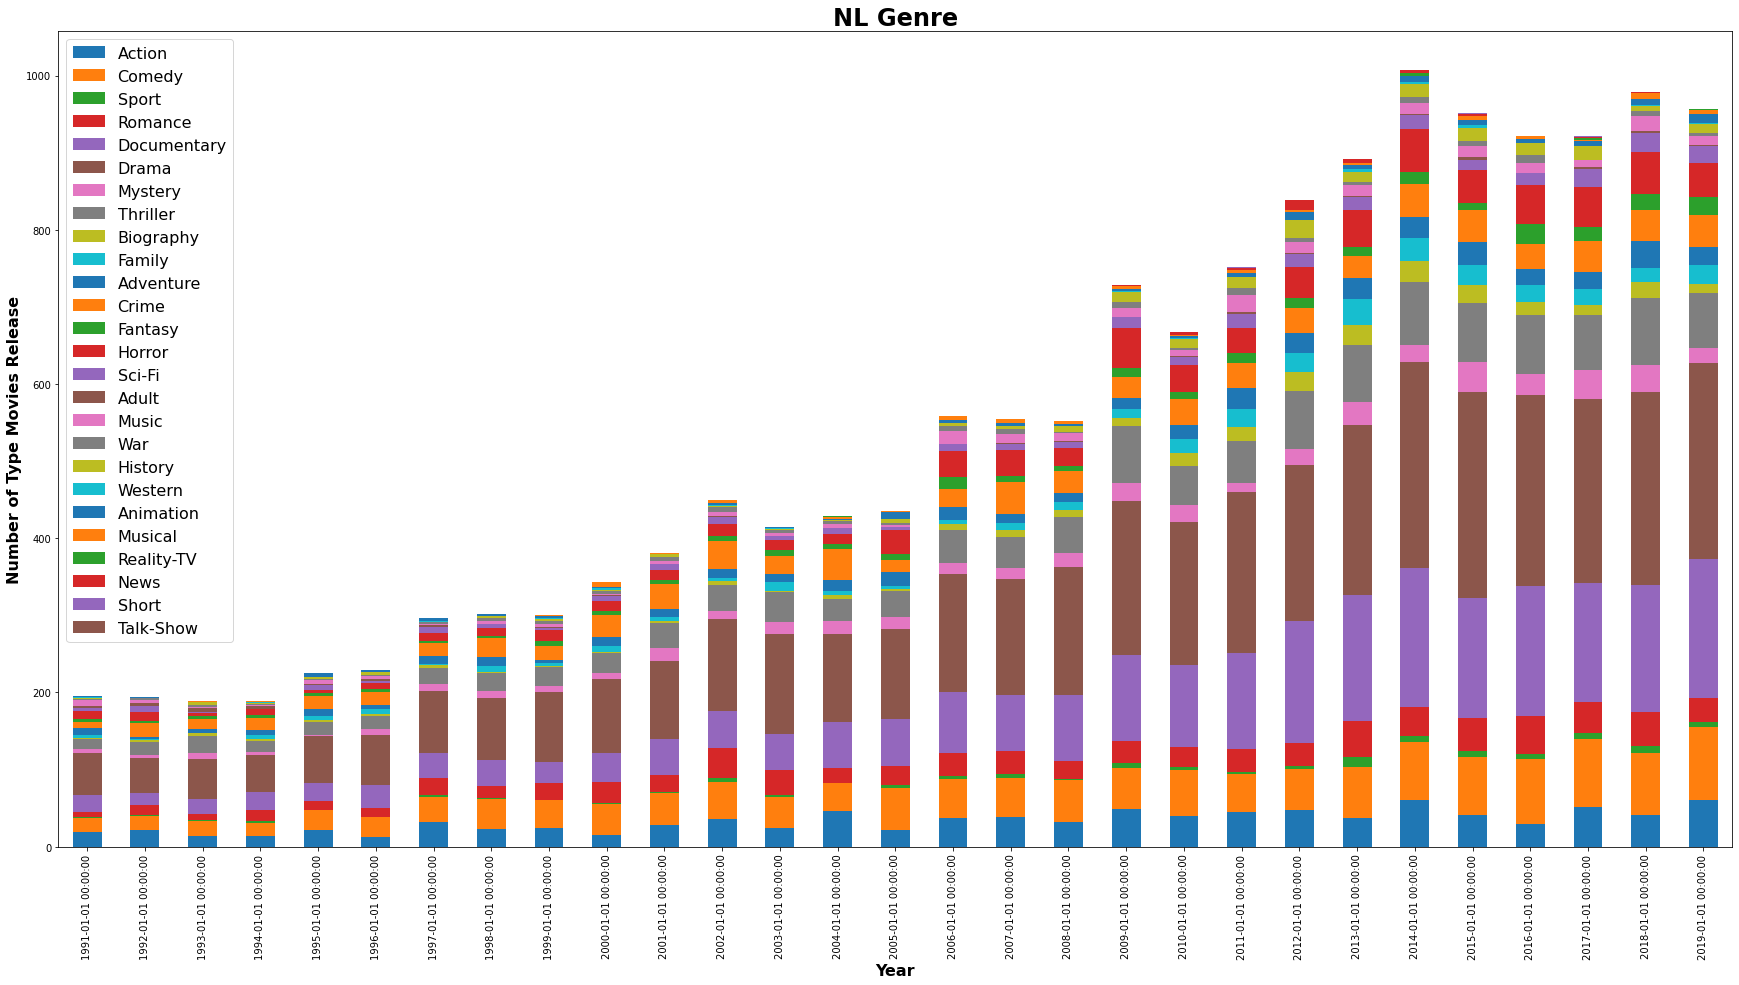

In [37]:
temp_NL = NL.iloc[1:, :]

gdp_plot =temp_NL.plot.bar(stacked=True, figsize = (30, 15))
gdp_plot.set_title('NL Genre', fontsize=24, fontweight='bold')
gdp_plot.set_xlabel('Year', fontsize=16, fontweight='bold')
gdp_plot.set_ylabel('Number of Type Movies Release', fontsize=16, fontweight='bold')
gdp_plot.legend(loc='best', prop={'size':16})

gdp_plot.figure.savefig(f"{images_dir}/NL_genre_time.png", dpi=400, bbox_inches='tight')

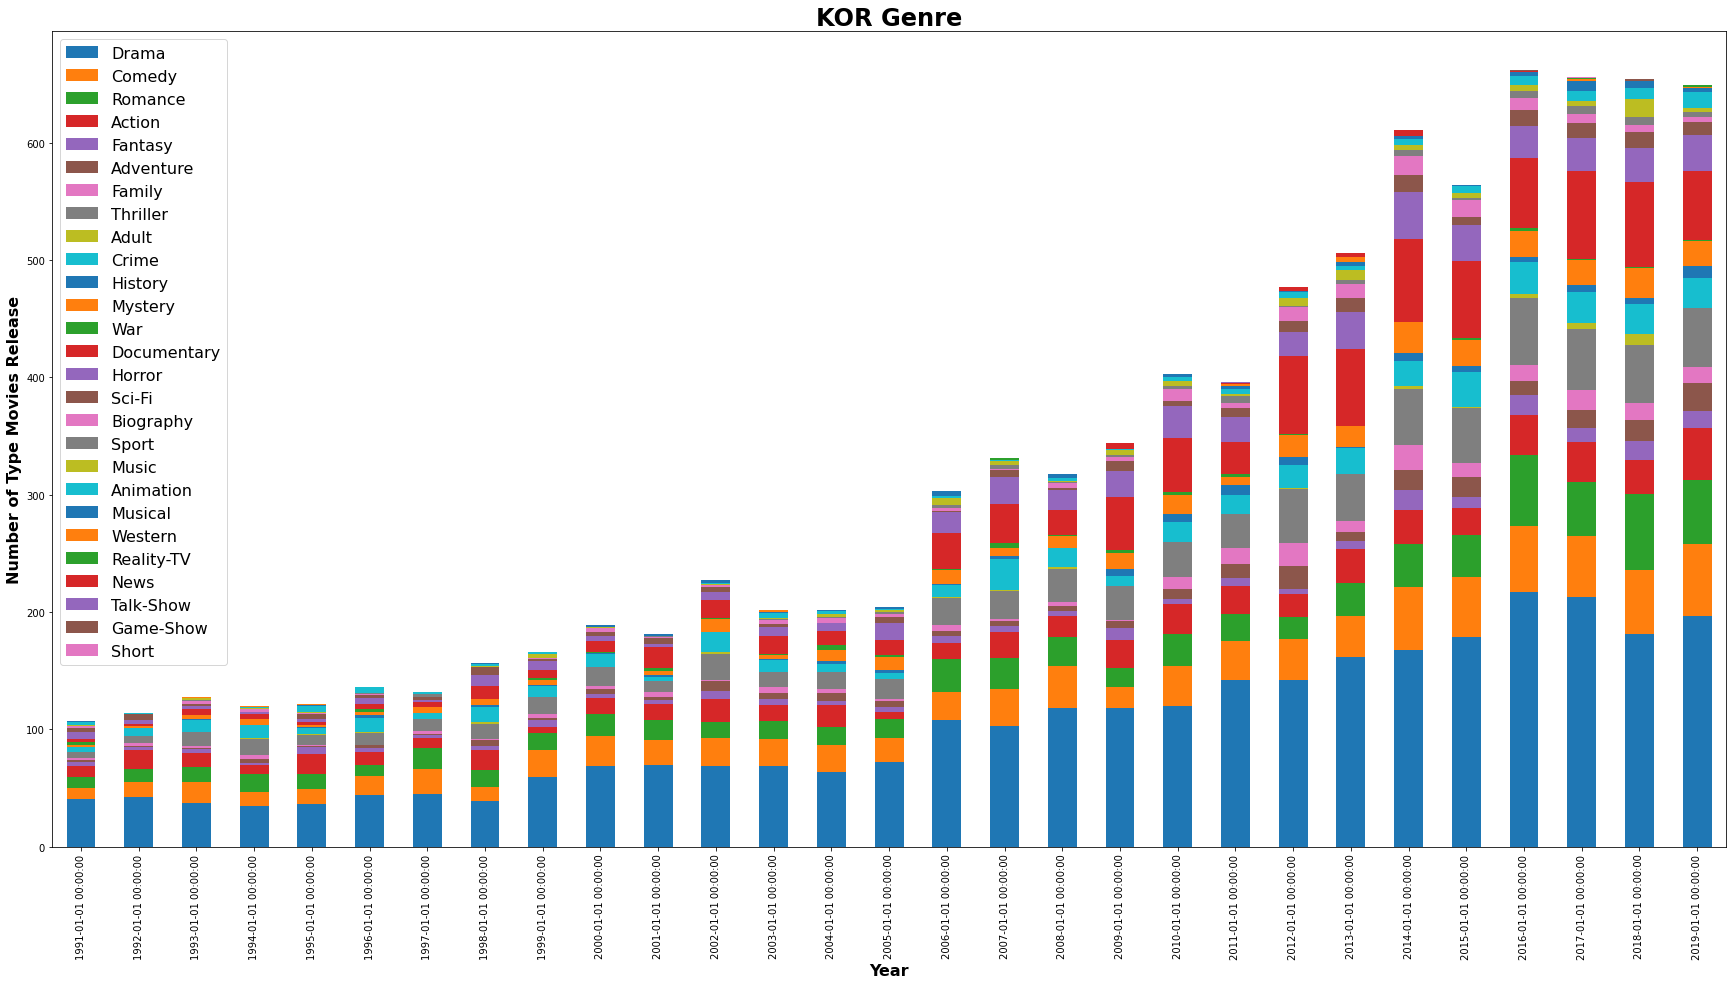

In [38]:
temp_SK = KRS.iloc[1:, :]

gdp_plot =temp_SK.plot.bar(stacked=True, figsize = (30, 15))
gdp_plot.set_title('KOR Genre', fontsize=24, fontweight='bold')
gdp_plot.set_xlabel('Year', fontsize=16, fontweight='bold')
gdp_plot.set_ylabel('Number of Type Movies Release', fontsize=16, fontweight='bold')
gdp_plot.legend(loc='best', prop={'size':16})

gdp_plot.figure.savefig(f"{images_dir}/KRS_genre_time.png", dpi=400, bbox_inches='tight')

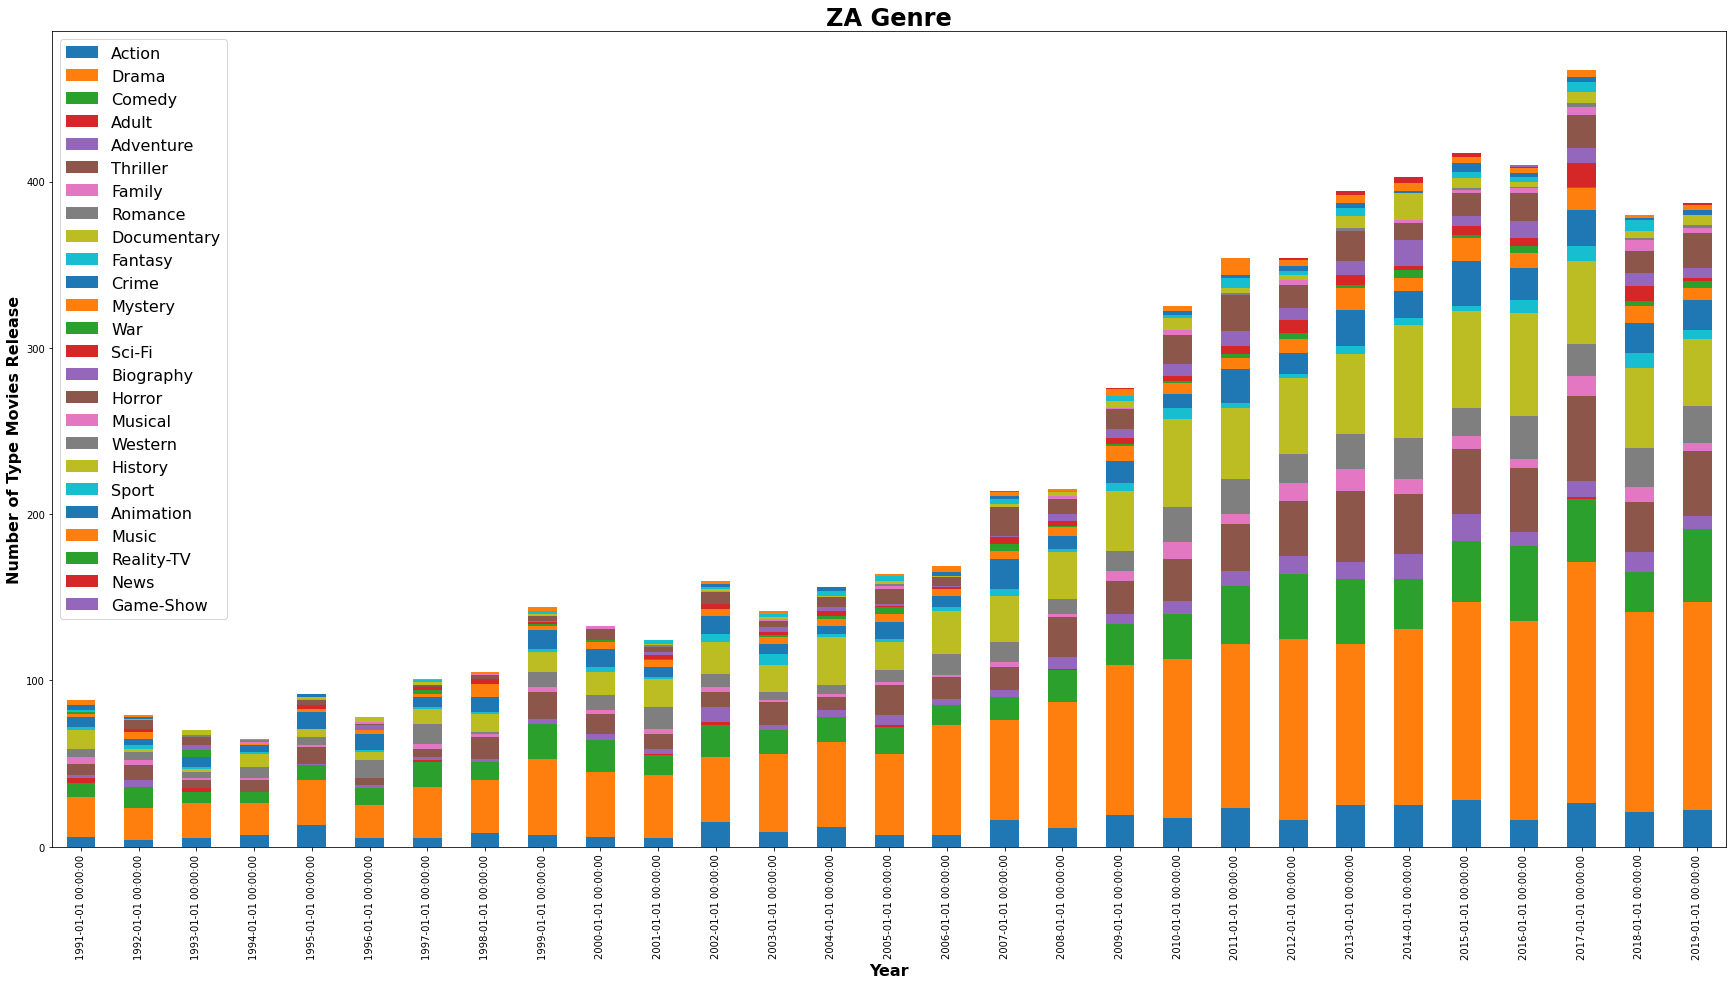

In [39]:
temp_ZA = ZA.iloc[1:, :]

gdp_plot =temp_ZA.plot.bar(stacked=True, figsize = (30, 15))
gdp_plot.set_title('ZA Genre', fontsize=24, fontweight='bold')
gdp_plot.set_xlabel('Year', fontsize=16, fontweight='bold')
gdp_plot.set_ylabel('Number of Type Movies Release', fontsize=16, fontweight='bold')
gdp_plot.legend(loc='best', prop={'size':16})

gdp_plot.figure.savefig(f"{images_dir}/ZA_genre_time.png", dpi=400, bbox_inches='tight')

Plot GDP / Genre

/usr/local/lib/python3.7/dist-packages/pandas/plotting/_matplotlib/tools.py:307: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
/usr/local/lib/python3.7/dist-packages/pandas/plotting/_matplotlib/tools.py:307: MatplotlibDeprecationWarning: 
The colNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().colspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
/usr/local/lib/python3.7/dist-packages/pandas/plotting/_matplotlib/tools.py:313: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  if not layout[ax.rowNum + 1, ax.colNum]:
/usr/local/lib/python3.7/dist-packages/pandas/plotting/_matplotlib/tools.py:3

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fa00a6b53d0>,
      dtype=object)

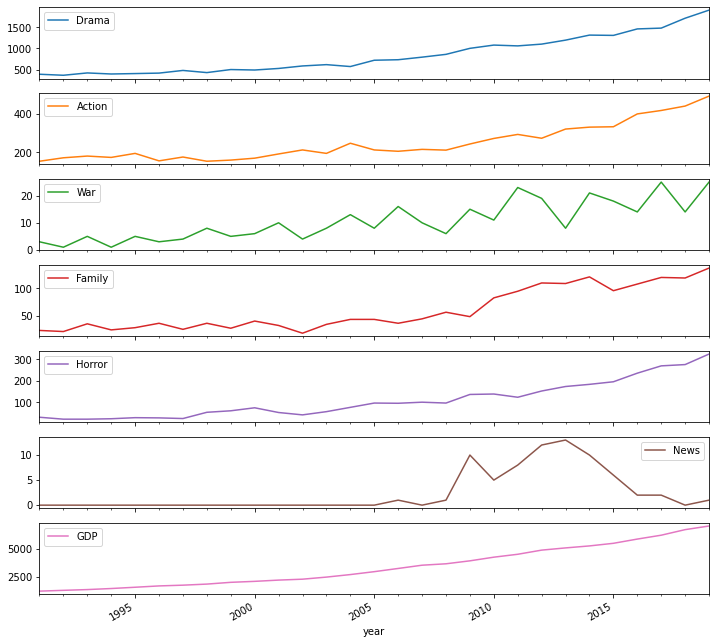

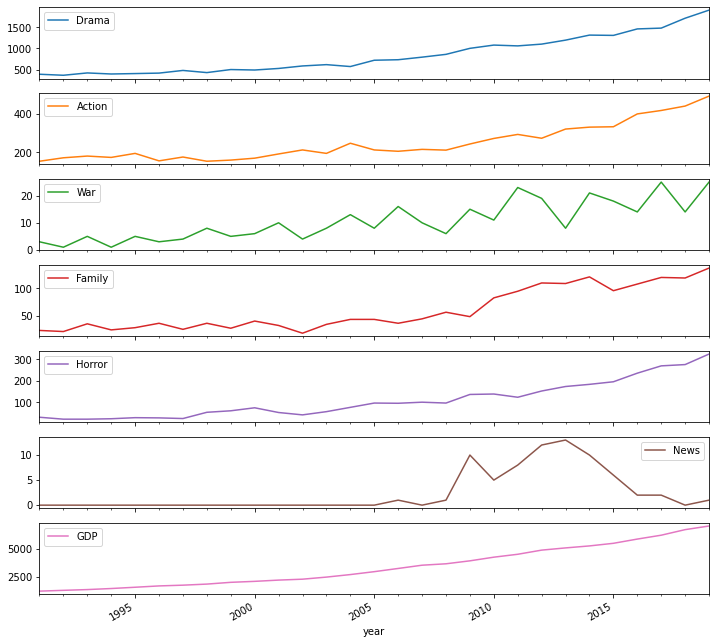

In [40]:
test = IND_GDP
test_new = test.cumsum()

val_plot = test.plot(subplots=True, figsize=(12, 12))
test.plot(subplots=True, figsize=(12, 12))



/usr/local/lib/python3.7/dist-packages/pandas/plotting/_matplotlib/tools.py:307: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
/usr/local/lib/python3.7/dist-packages/pandas/plotting/_matplotlib/tools.py:307: MatplotlibDeprecationWarning: 
The colNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().colspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
/usr/local/lib/python3.7/dist-packages/pandas/plotting/_matplotlib/tools.py:313: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  if not layout[ax.rowNum + 1, ax.colNum]:
/usr/local/lib/python3.7/dist-packages/pandas/plotting/_matplotlib/tools.py:3

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f9fe8546150>,
      dtype=object)

<Figure size 432x288 with 0 Axes>

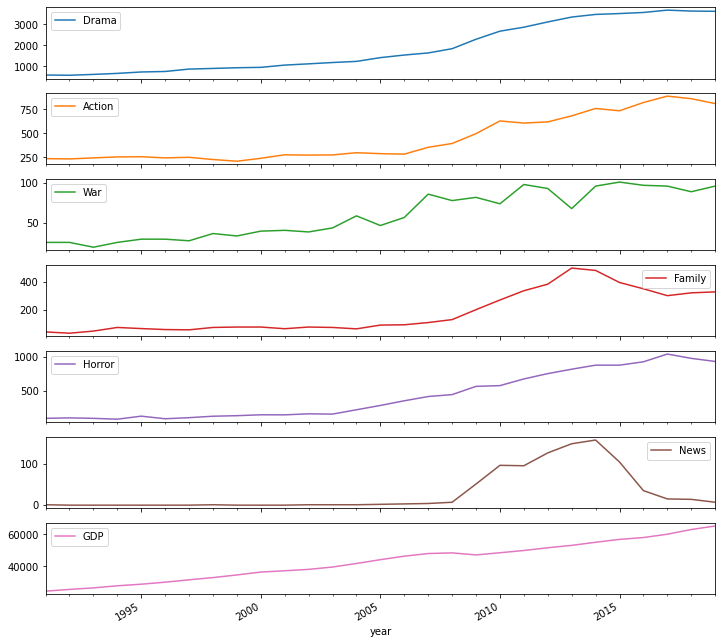

In [41]:
test = US_GDP
test_new = test.cumsum()

plt.figure()


test.plot(subplots=True, figsize=(12, 12))



/usr/local/lib/python3.7/dist-packages/pandas/plotting/_matplotlib/tools.py:307: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
/usr/local/lib/python3.7/dist-packages/pandas/plotting/_matplotlib/tools.py:307: MatplotlibDeprecationWarning: 
The colNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().colspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
/usr/local/lib/python3.7/dist-packages/pandas/plotting/_matplotlib/tools.py:313: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  if not layout[ax.rowNum + 1, ax.colNum]:
/usr/local/lib/python3.7/dist-packages/pandas/plotting/_matplotlib/tools.py:3

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f9fcd268350>,
      dtype=object)

<Figure size 432x288 with 0 Axes>

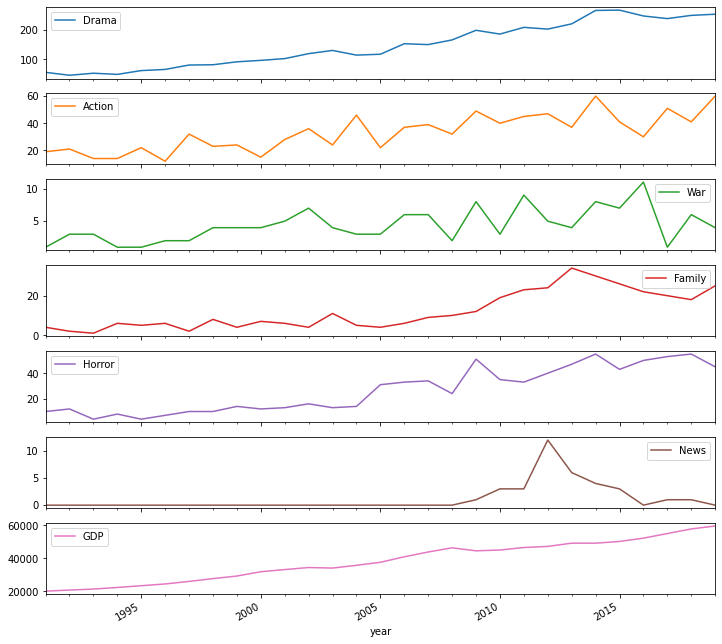

In [42]:
test = NL_GDP
test_new = test.cumsum()

plt.figure()


test.plot(subplots=True, figsize=(12, 12))


/usr/local/lib/python3.7/dist-packages/pandas/plotting/_matplotlib/tools.py:307: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
/usr/local/lib/python3.7/dist-packages/pandas/plotting/_matplotlib/tools.py:307: MatplotlibDeprecationWarning: 
The colNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().colspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
/usr/local/lib/python3.7/dist-packages/pandas/plotting/_matplotlib/tools.py:313: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  if not layout[ax.rowNum + 1, ax.colNum]:
/usr/local/lib/python3.7/dist-packages/pandas/plotting/_matplotlib/tools.py:3

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f9fcdc74510>,
      dtype=object)

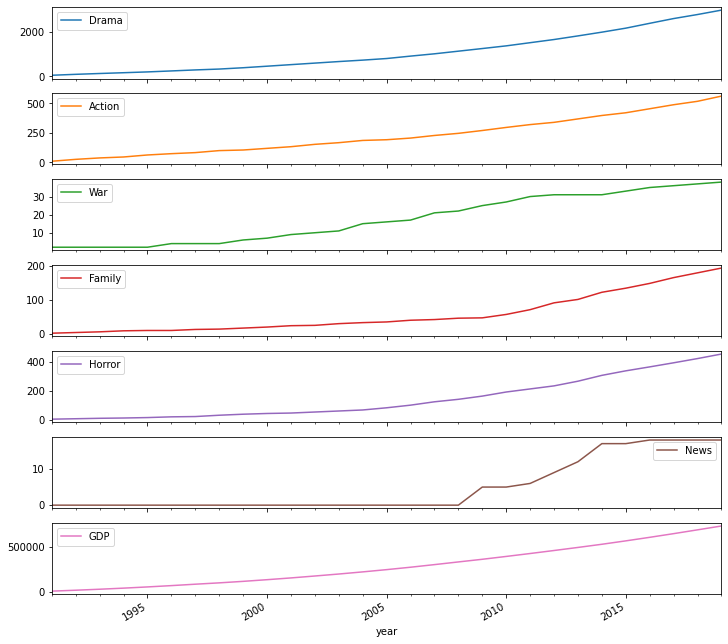

In [43]:
SK_plt = KOR_GDP.cumsum()


SK_plt.plot(subplots=True, figsize=(12, 12))


Genre/ Religion

/usr/local/lib/python3.7/dist-packages/pandas/plotting/_matplotlib/tools.py:307: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
/usr/local/lib/python3.7/dist-packages/pandas/plotting/_matplotlib/tools.py:307: MatplotlibDeprecationWarning: 
The colNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().colspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
/usr/local/lib/python3.7/dist-packages/pandas/plotting/_matplotlib/tools.py:313: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  if not layout[ax.rowNum + 1, ax.colNum]:
/usr/local/lib/python3.7/dist-packages/pandas/plotting/_matplotlib/tools.py:3

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f9fcfb25d90>,
      dtype=object)

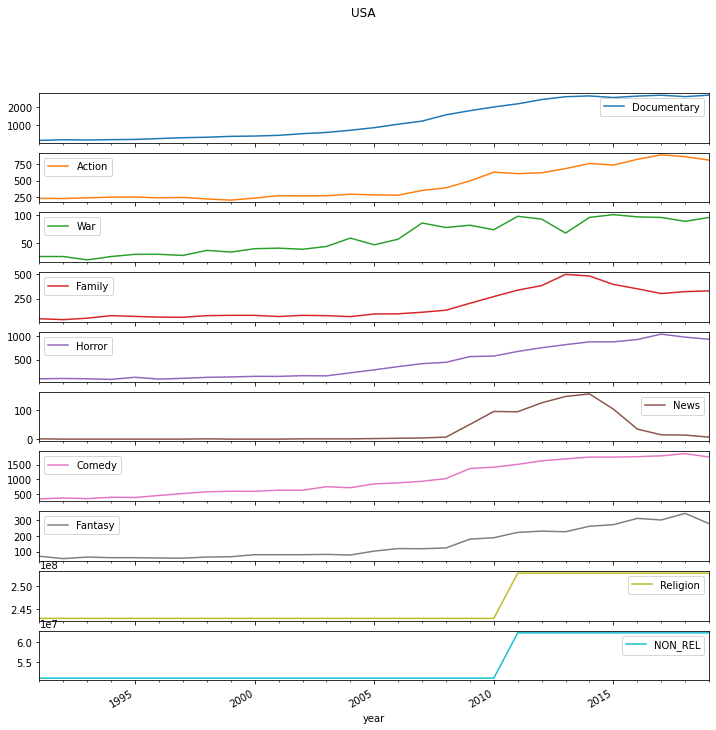

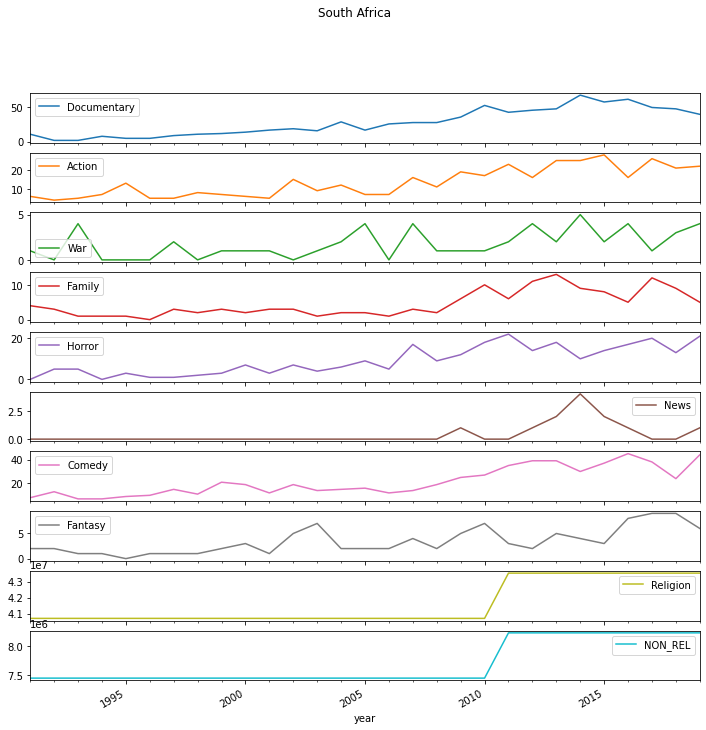

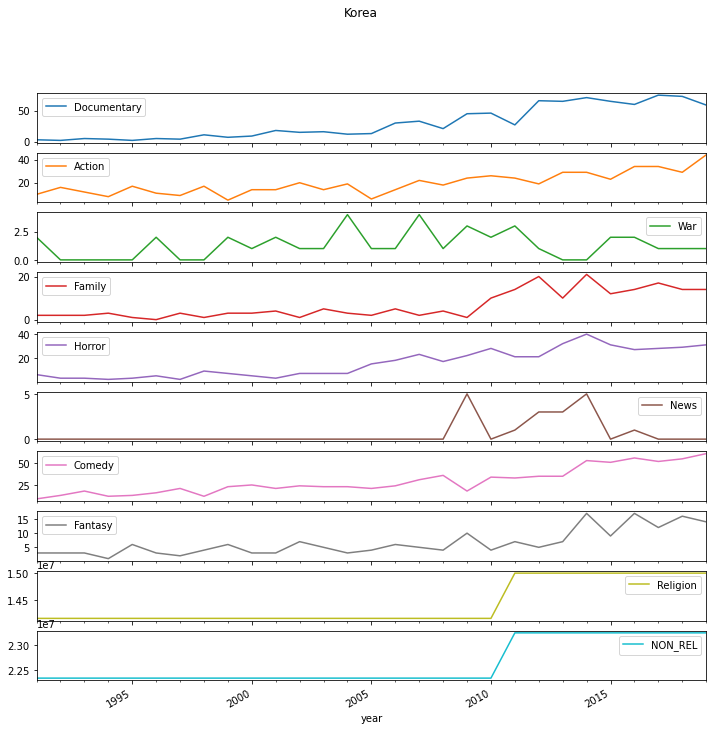

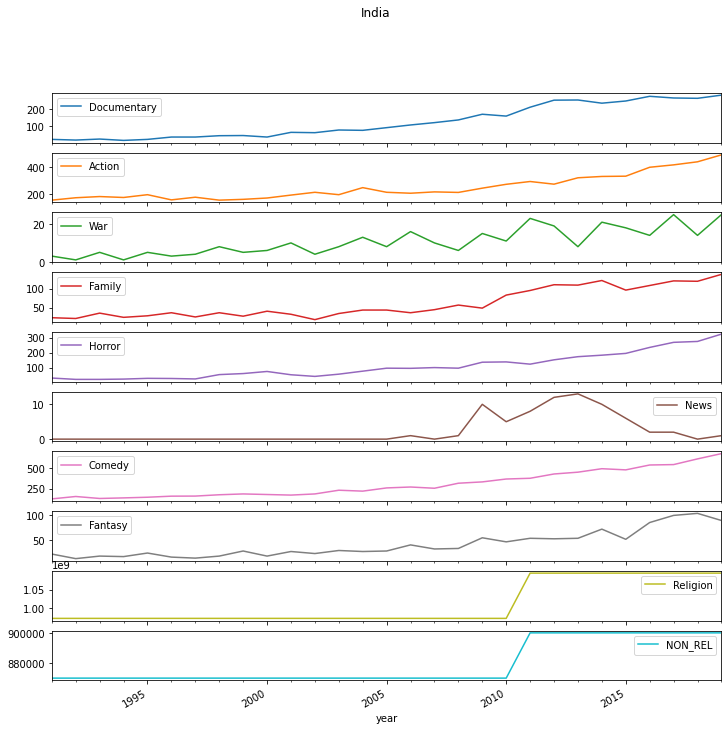

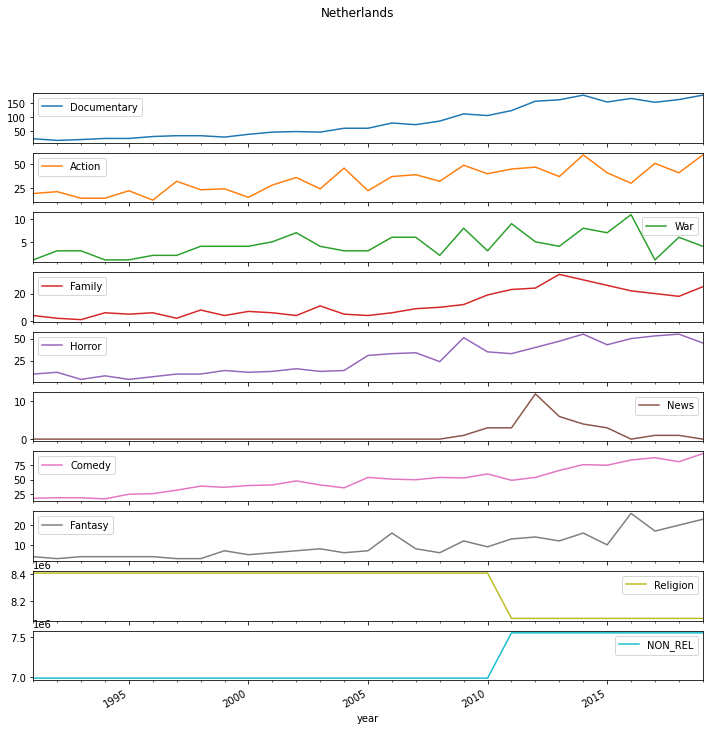

In [44]:
US_REL.plot(subplots=True, figsize=(12, 12), title = "USA")
ZA_REL.plot(subplots=True, figsize=(12, 12), title = "South Africa")
KOR_REL.plot(subplots=True, figsize=(12, 12), title = "Korea")
IND_REL.plot(subplots=True, figsize=(12, 12), title = "India")
NL_REL.plot(subplots=True, figsize=(12, 12), title = "Netherlands")


Population / Genre

/usr/local/lib/python3.7/dist-packages/pandas/plotting/_matplotlib/tools.py:307: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
/usr/local/lib/python3.7/dist-packages/pandas/plotting/_matplotlib/tools.py:307: MatplotlibDeprecationWarning: 
The colNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().colspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
/usr/local/lib/python3.7/dist-packages/pandas/plotting/_matplotlib/tools.py:313: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  if not layout[ax.rowNum + 1, ax.colNum]:
/usr/local/lib/python3.7/dist-packages/pandas/plotting/_matplotlib/tools.py:3

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f9fd0288e10>,
      dtype=object)

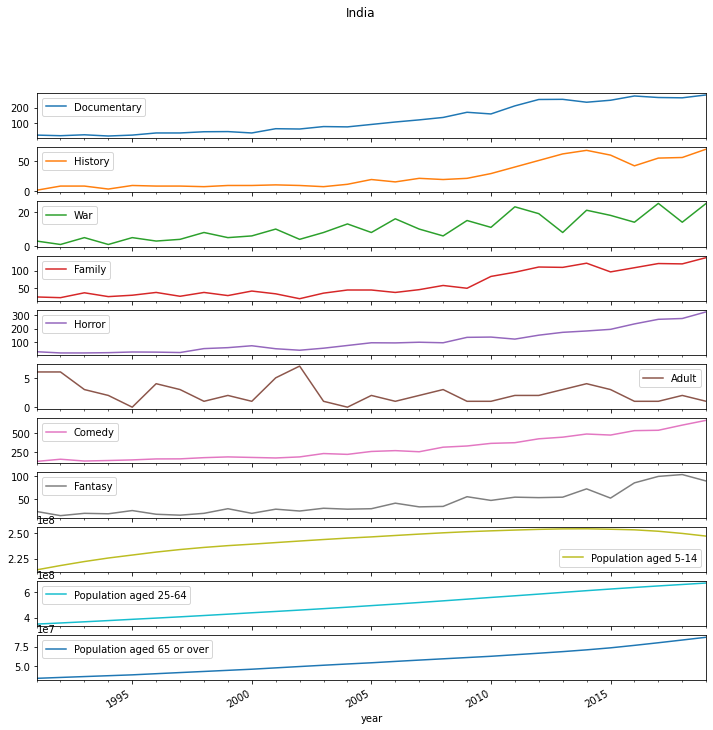

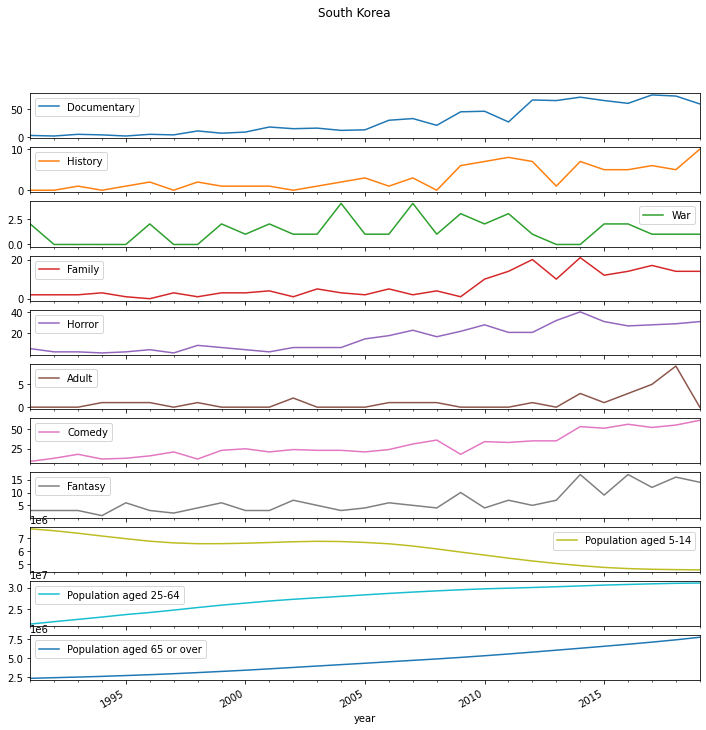

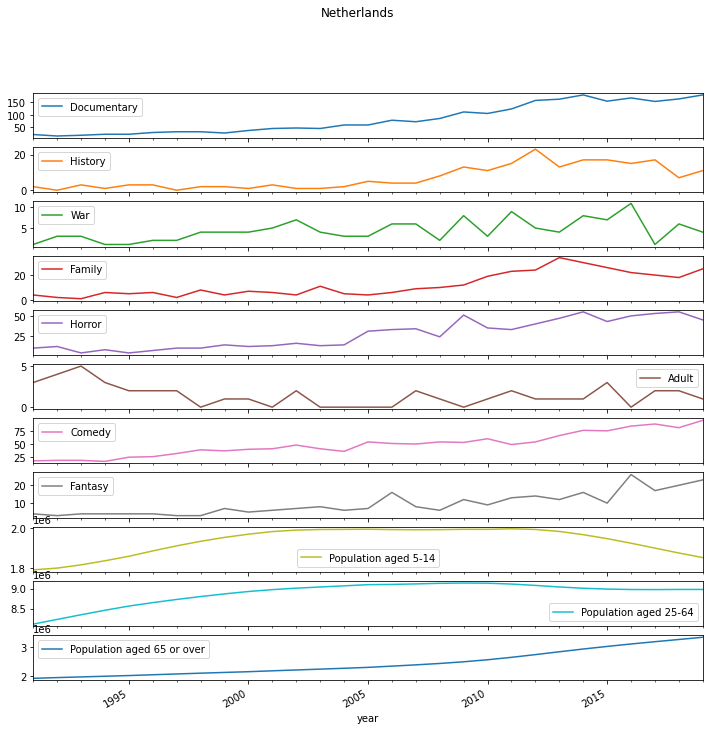

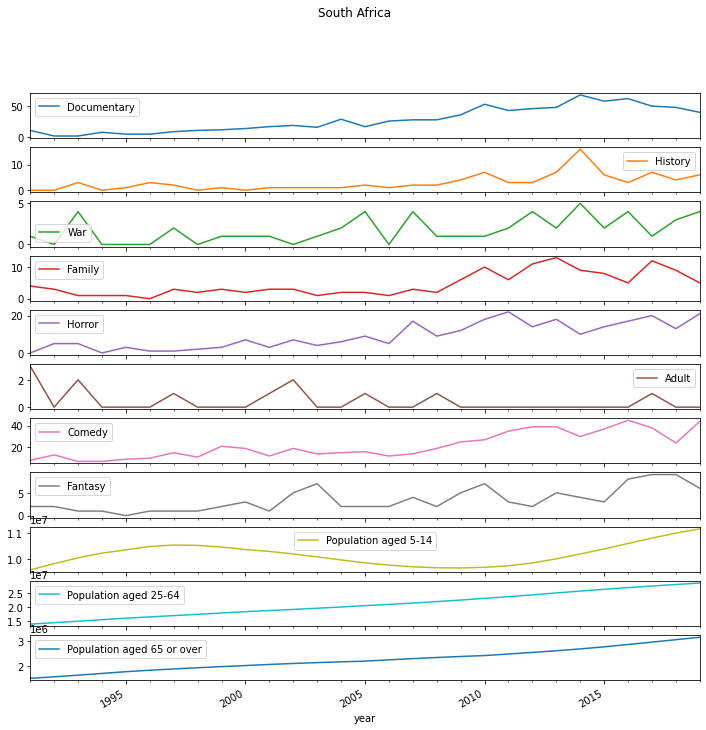

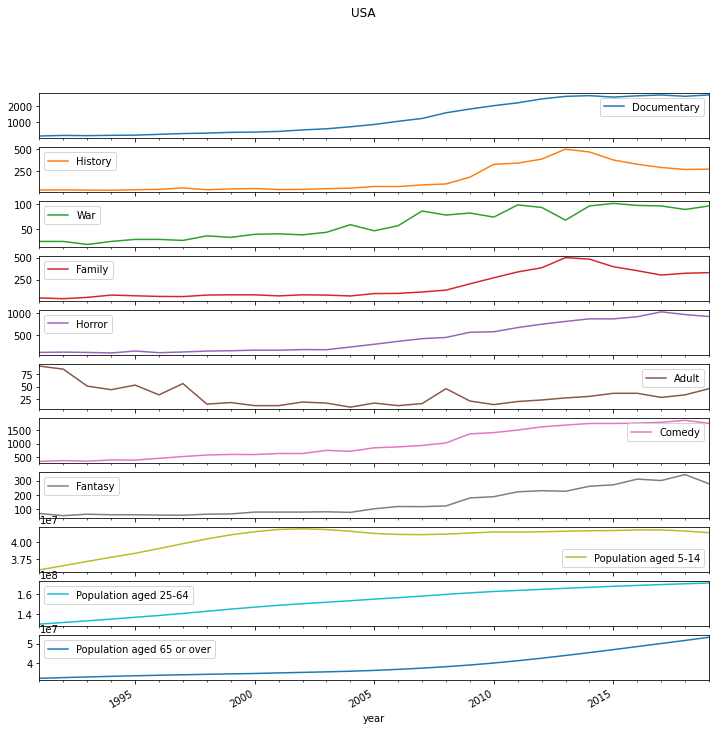

In [45]:
IND_POP.plot(subplots=True, figsize=(12, 12), title = 'India')
KOR_POP.plot(subplots=True, figsize=(12, 12), title = 'South Korea')
NL_POP.plot(subplots=True, figsize=(12, 12), title = 'Netherlands')
ZA_POP.plot(subplots=True, figsize=(12, 12), title = "South Africa")
US_POP.plot(subplots=True, figsize=(12, 12), title = "USA")



Goverment / Genre

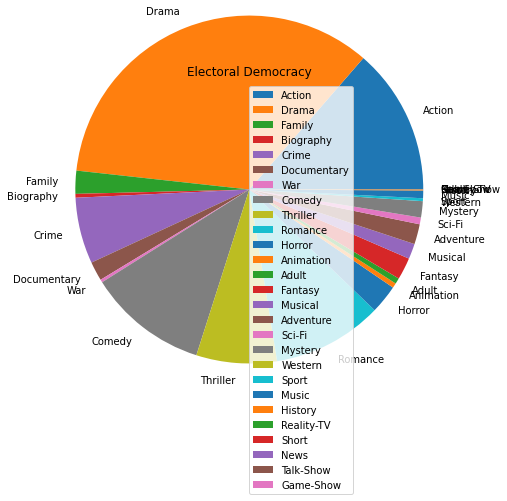

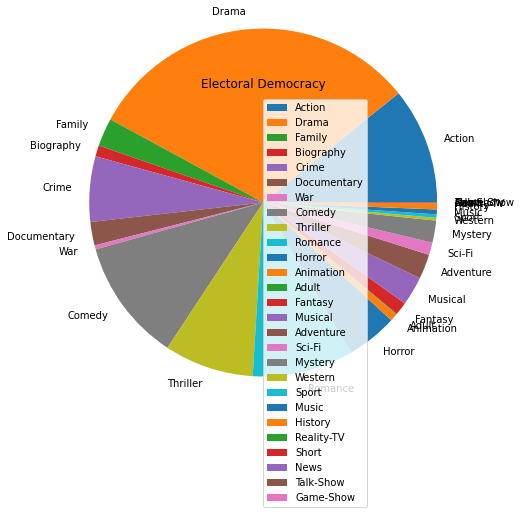

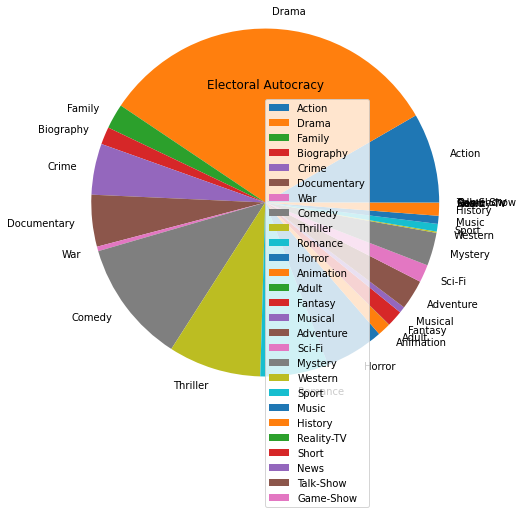

In [46]:
plt.figure(0)

plt.pie(IND_GOVA.iloc[0], labels = IND_GOVA.columns, radius = 2) 
plt.legend()
plt.title(IND_df.loc[IND_df['Year'] == '1991', 'Political regime'].iloc[0])
 
plt.figure(1)
plt.pie(IND_GOVB.iloc[0], labels = IND_GOVB.columns, radius = 2) 
plt.legend()
plt.title(IND_df.loc[IND_df['Year'] == '2000', 'Political regime'].iloc[0])

plt.figure(2)
plt.pie(IND_GOVC.iloc[0], labels = IND_GOVC.columns, radius = 2) 
plt.legend()
plt.title(IND_df.loc[IND_df['Year'] == '2020', 'Political regime'].iloc[0])

plt.show()



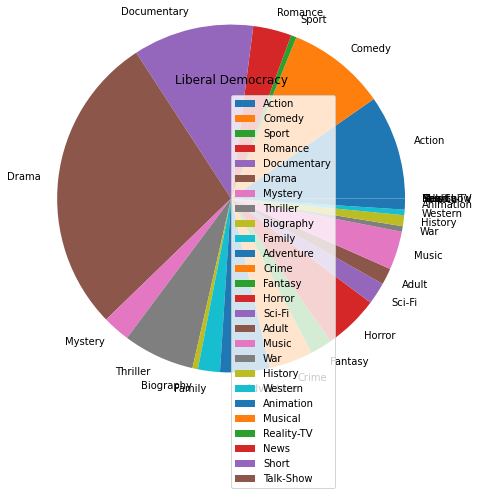

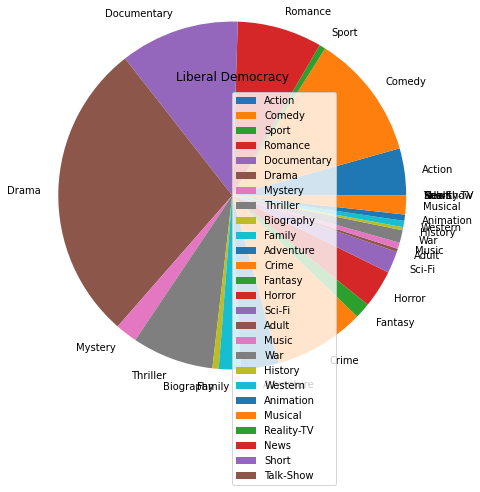

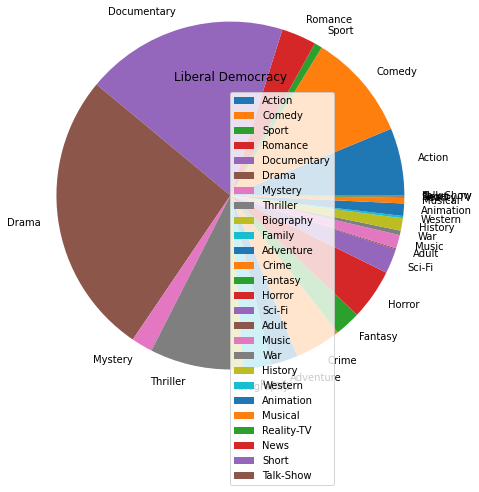

In [47]:
plt.figure(0)

plt.pie(NL_GOVA.iloc[0], labels = NL_GOVA.columns, radius = 2) 
plt.legend()
plt.title(NL_df.loc[NL_df['Year'] == '1991', 'Political regime'].iloc[0])
 
plt.figure(1)
plt.pie(NL_GOVB.iloc[0], labels = NL_GOVB.columns, radius = 2) 
plt.legend()
plt.title(NL_df.loc[IND_df['Year'] == '2000', 'Political regime'].iloc[0])

plt.figure(2)
plt.pie(NL_GOVC.iloc[0], labels = NL_GOVC.columns, radius = 2) 
plt.legend()
plt.title(NL_df.loc[NL_df['Year'] == '2020', 'Political regime'].iloc[0])

plt.show()

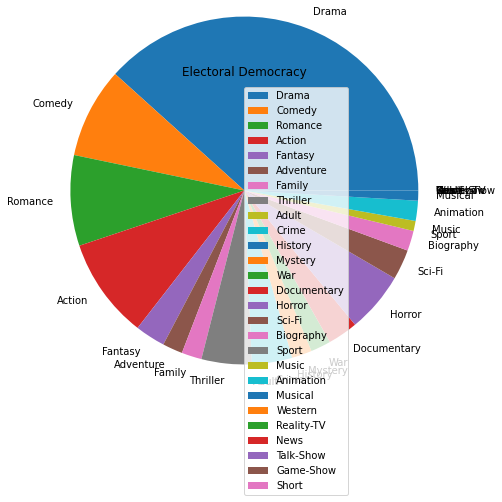

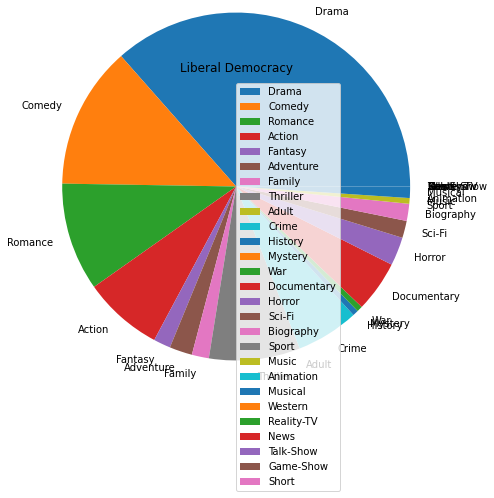

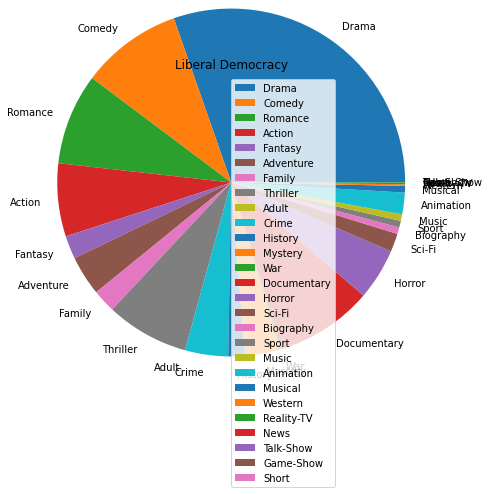

In [48]:
plt.figure(0)

plt.pie(KOR_GOVA.iloc[0], labels = KOR_GOVA.columns, radius = 2) 
plt.legend()
plt.title(KOR_df.loc[KOR_df['Year'] == '1991', 'Political regime'].iloc[0])
 
plt.figure(1)
plt.pie(KOR_GOVB.iloc[0], labels = KOR_GOVB.columns, radius = 2) 
plt.legend()
plt.title(KOR_df.loc[KOR_df['Year'] == '2000', 'Political regime'].iloc[0])

plt.figure(2)
plt.pie(KOR_GOVC.iloc[0], labels = KOR_GOVC.columns, radius = 2) 
plt.legend()
plt.title(KOR_df.loc[KOR_df['Year'] == '2020', 'Political regime'].iloc[0])

plt.show()

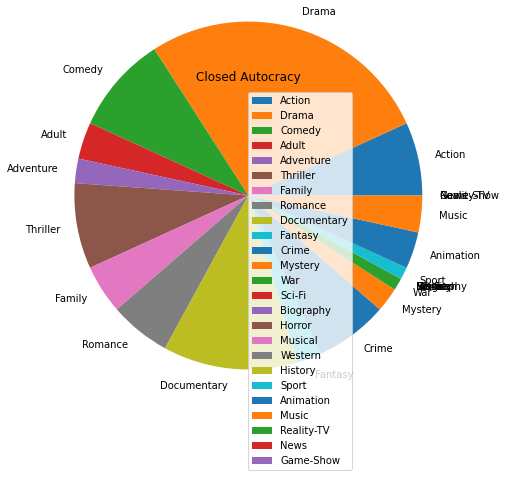

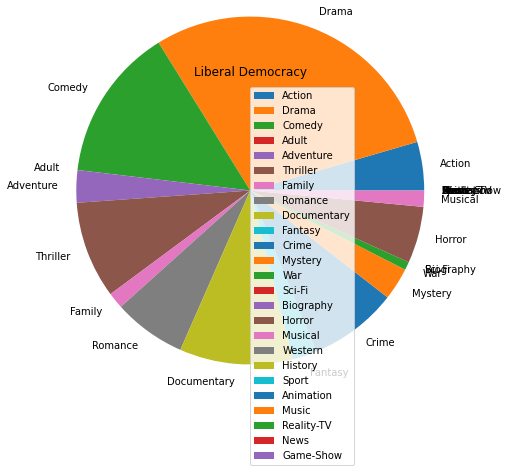

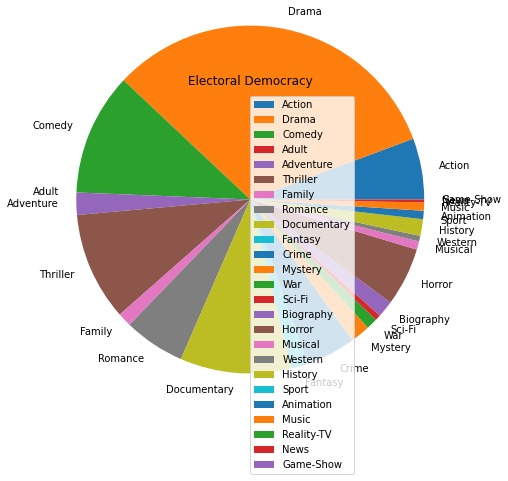

In [49]:
plt.figure(0)

plt.pie(ZA_GOVA.iloc[0], labels = ZA_GOVA.columns, radius = 2) 
plt.legend()
plt.title(ZA_df.loc[ZA_df['Year'] == '1991', 'Political regime'].iloc[0])
 
plt.figure(1)
plt.pie(ZA_GOVB.iloc[0], labels = ZA_GOVB.columns, radius = 2) 
plt.legend()
plt.title(ZA_df.loc[ZA_df['Year'] == '2000', 'Political regime'].iloc[0])

plt.figure(2)
plt.pie(ZA_GOVC.iloc[0], labels = ZA_GOVC.columns, radius = 2) 
plt.legend()
plt.title(ZA_df.loc[ZA_df['Year'] == '2020', 'Political regime'].iloc[0])

plt.show()

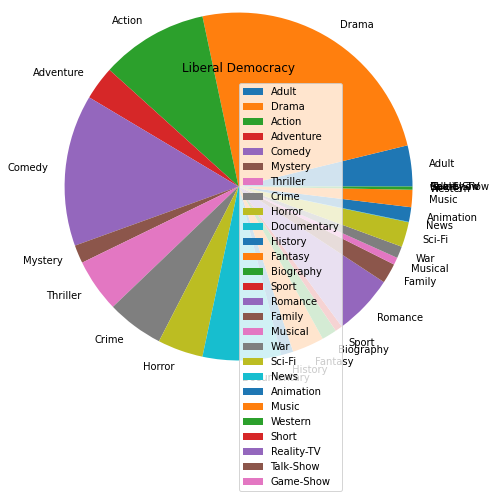

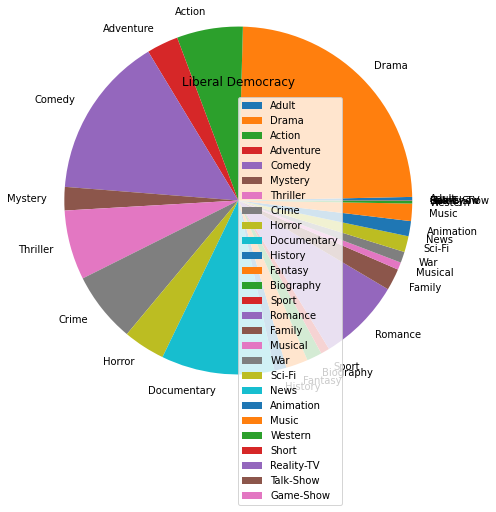

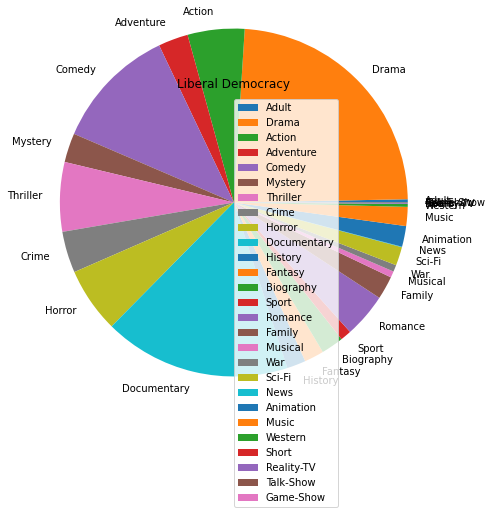

In [50]:
plt.figure(0)

plt.pie(US_GOVA.iloc[0], labels = US_GOVA.columns, radius = 2) 
plt.legend()
plt.title(USA_df.loc[USA_df['Year'] == '1991', 'Political regime'].iloc[0])
 
plt.figure(1)
plt.pie(US_GOVB.iloc[0], labels = US_GOVB.columns, radius = 2) 
plt.legend()
plt.title(USA_df.loc[USA_df['Year'] == '2000', 'Political regime'].iloc[0])

plt.figure(2)
plt.pie(US_GOVC.iloc[0], labels = US_GOVC.columns, radius = 2) 
plt.legend()
plt.title(USA_df.loc[USA_df['Year'] == '2020', 'Political regime'].iloc[0])

plt.show()

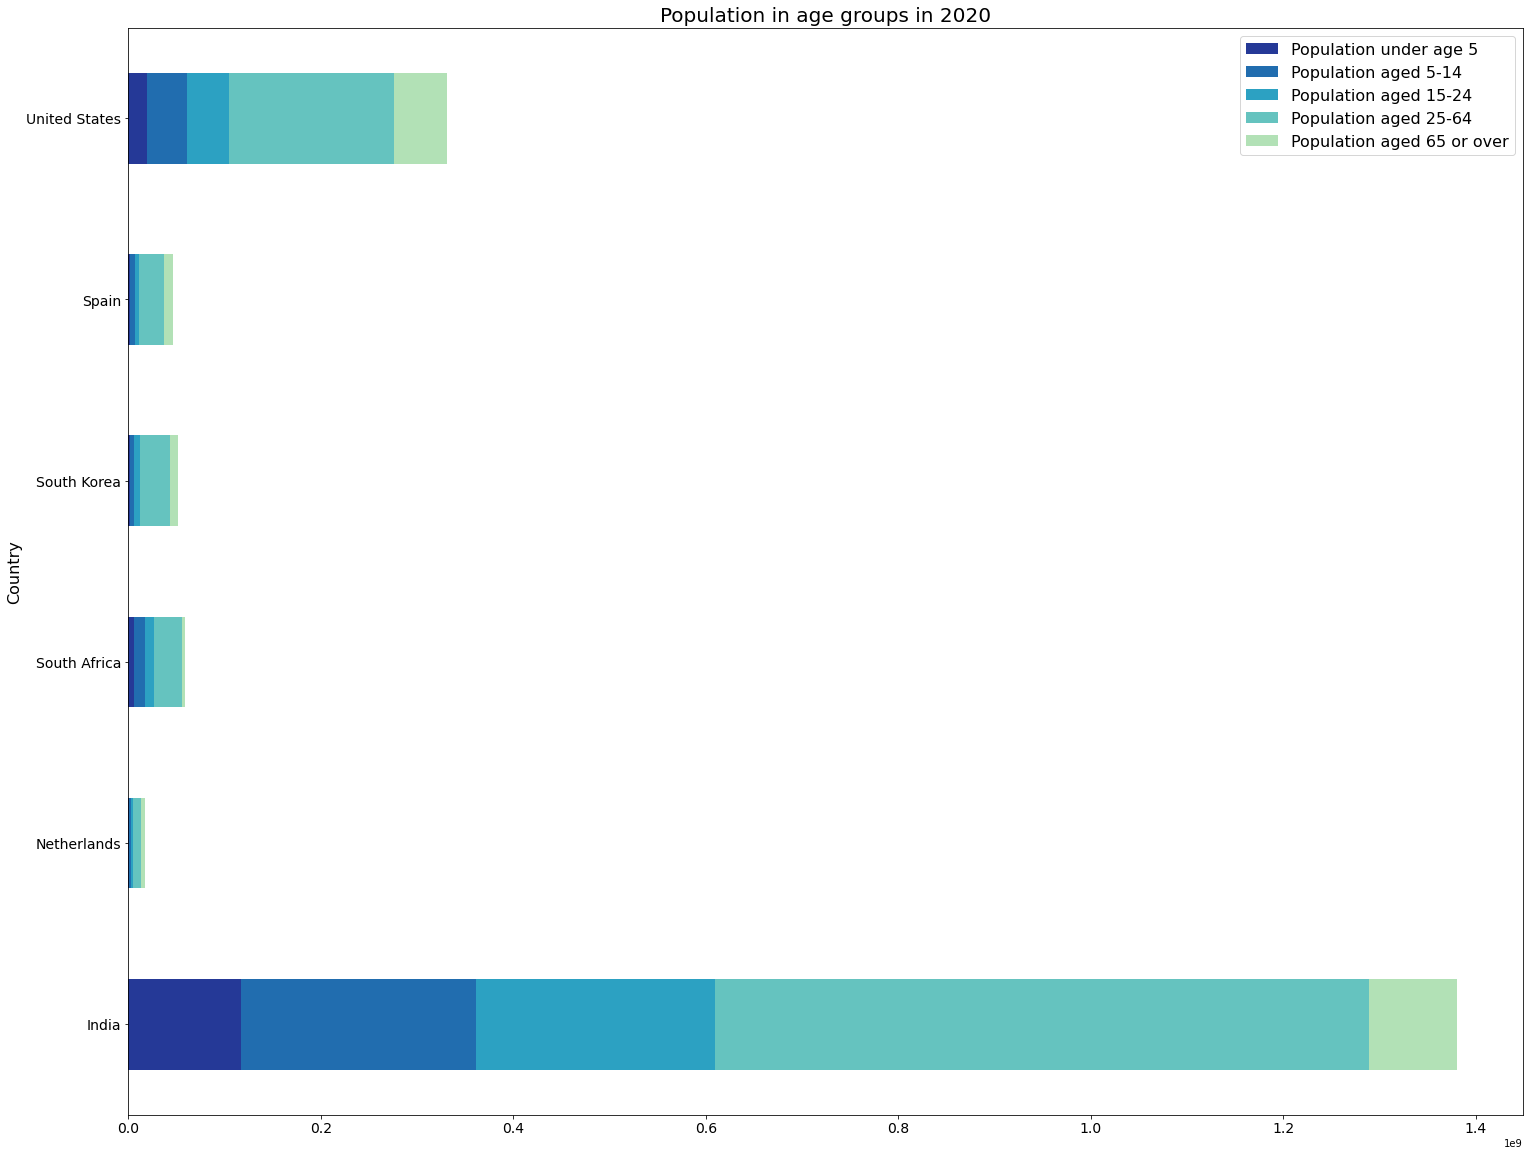

In [51]:
# the division of the population per country is depicted in a horizontal barplot to show the difference in population  
age_barplot = df_pop_2020.plot.barh(stacked=True, color=colors, figsize=(25, 20))
age_barplot.set_title('Population in age groups in 2020', fontsize = 20)
age_barplot.set_ylabel('Country', fontsize=16)
age_barplot.tick_params(axis='y', labelsize=14)
age_barplot.tick_params(axis='x', labelsize=14)
age_barplot.legend(loc='best', prop={'size':16})

age_barplot.figure.savefig(f"{images_dir}/age_barplot.png", dpi=400, bbox_inches='tight')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: MatplotlibDeprecationWarning: Non-1D inputs to pie() are currently squeeze()d, but this behavior is deprecated since 3.1 and will be removed in 3.3; pass a 1D array instead.
  from ipykernel import kernelapp as app
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Non-1D inputs to pie() are currently squeeze()d, but this behavior is deprecated since 3.1 and will be removed in 3.3; pass a 1D array instead.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Non-1D inputs to pie() are currently squeeze()d, but this behavior is deprecated since 3.1 and will be removed in 3.3;

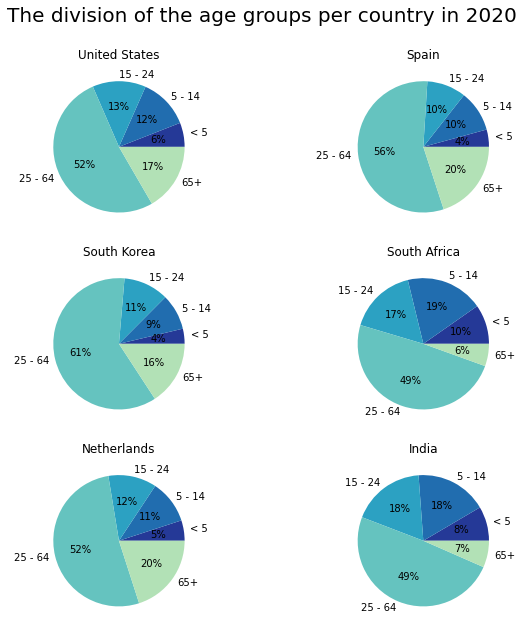

In [52]:
# to clearly see the difference in the division in age groups of the populations, the data per country is visualized in a pie chart 
age_fig = plt.figure(figsize=(10, 10), constrained_layout=True)
age_fig.suptitle('The division of the age groups per country in 2020', fontsize = 20)
age_fig.subplots_adjust(top=0.9)

ax1 = age_fig.add_subplot(3, 2, 1)
ax2 = age_fig.add_subplot(3, 2, 2)
ax3 = age_fig.add_subplot(3, 2, 3)
ax4 = age_fig.add_subplot(3, 2, 4)
ax5 = age_fig.add_subplot(3, 2, 5)
ax6 = age_fig.add_subplot(3, 2, 6)

labels = ['< 5', '5 - 14', '15 - 24', '25 - 64', '65+'] 
ax1.set_title('United States')
ax1.pie(df_pop_2020.loc[['United States']], labels=labels, colors=colors, autopct='%.0f%%')

ax2.set_title('Spain')
ax2.pie(df_pop_2020.loc[['Spain']], labels=labels, colors=colors, autopct='%.0f%%')

ax3.set_title('South Korea')
ax3.pie(df_pop_2020.loc[['South Korea']], labels=labels, colors=colors, autopct='%.0f%%')

ax4.set_title('South Africa')
ax4.pie(df_pop_2020.loc[['South Africa']], labels=labels, colors=colors, autopct='%.0f%%')

ax5.set_title('Netherlands')
ax5.pie(df_pop_2020.loc[['Netherlands']], labels=labels, colors=colors, autopct='%.0f%%')

ax6.set_title('India')
ax6.pie(df_pop_2020.loc[['India']], labels=labels, colors=colors, autopct='%.0f%%')

age_fig.savefig(f"{images_dir}/age_groups.png", dpi=400, bbox_inches='tight')

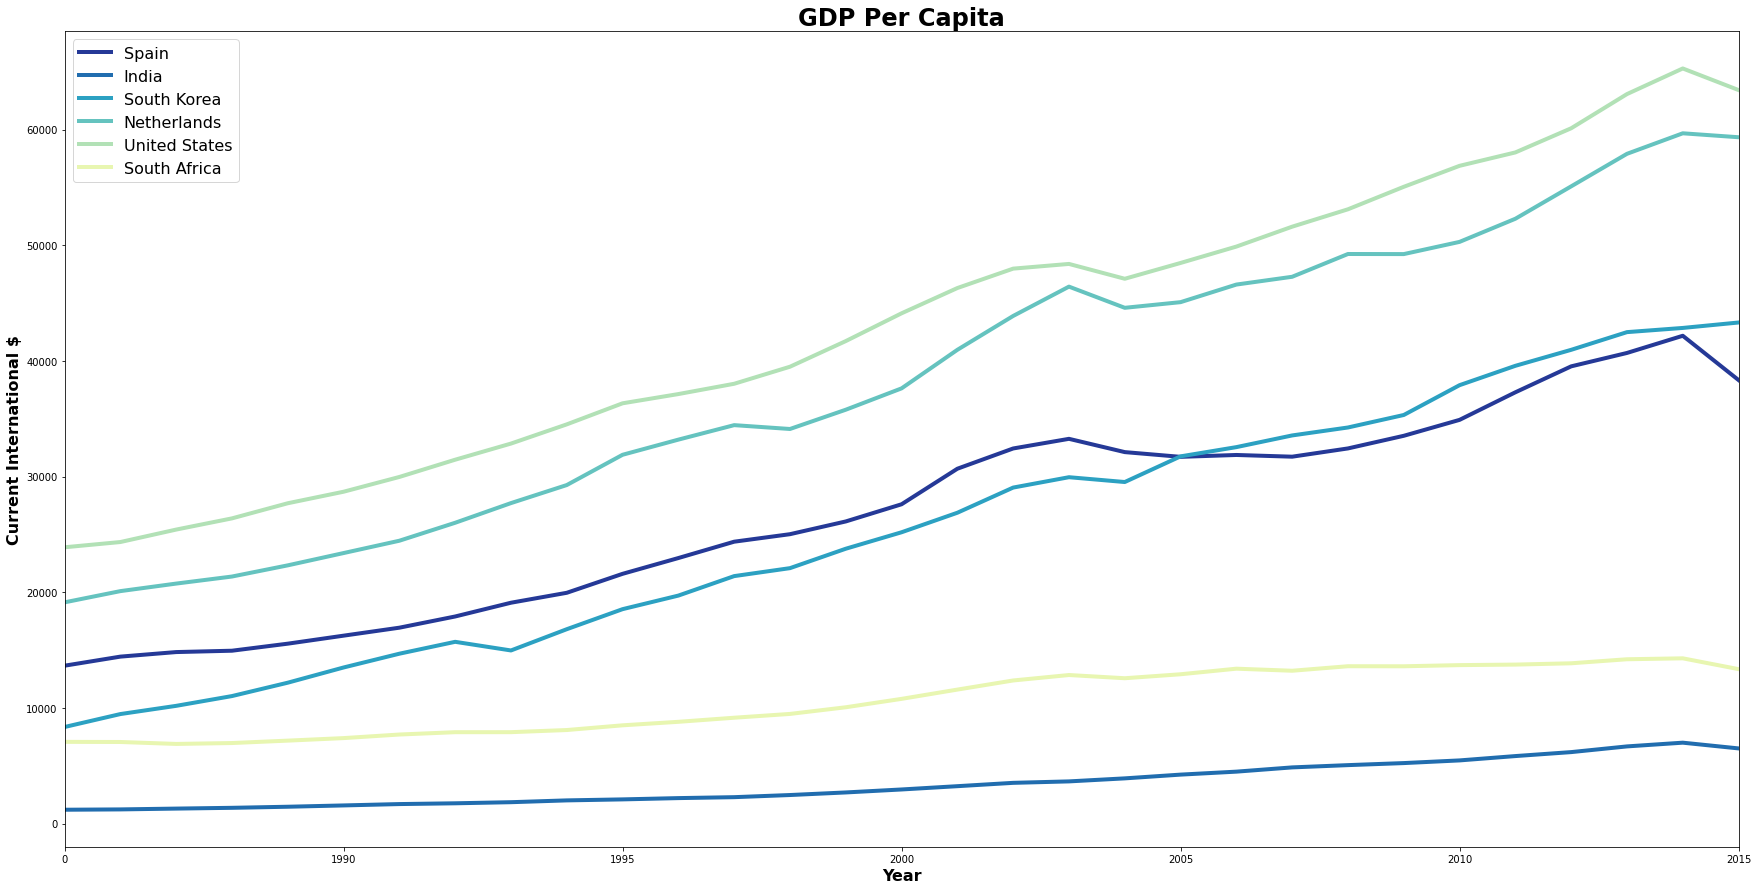

In [53]:
# how the GDP per capita has changed over the last years 
df_gdp = df_gdp_pcap.drop(columns=['Country Code', 'Indicator Name', 'Indicator Code']).set_index('Country Name')

gdp_plot = df_gdp.T.plot(color=colors, figsize = (30, 15), linewidth=4.0)
gdp_plot.set_title('GDP Per Capita', fontsize=24, fontweight='bold')
gdp_plot.set_xlabel('Year', fontsize=16, fontweight='bold')
gdp_plot.set_ylabel('Current International $', fontsize=16, fontweight='bold')
gdp_plot.set_xticklabels([0,1990, 1995, 2000, 2005, 2010, 2015, 2020])
gdp_plot.legend(loc='best', prop={'size':16})

gdp_plot.figure.savefig(f"{images_dir}/gdp_development.png", dpi=400, bbox_inches='tight')

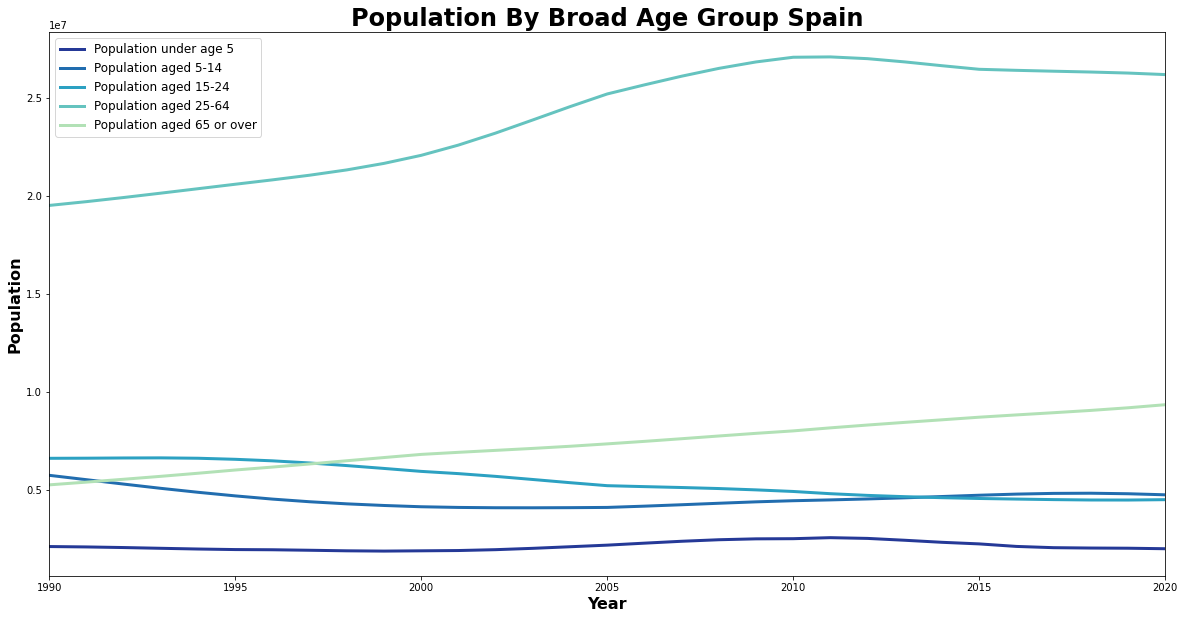

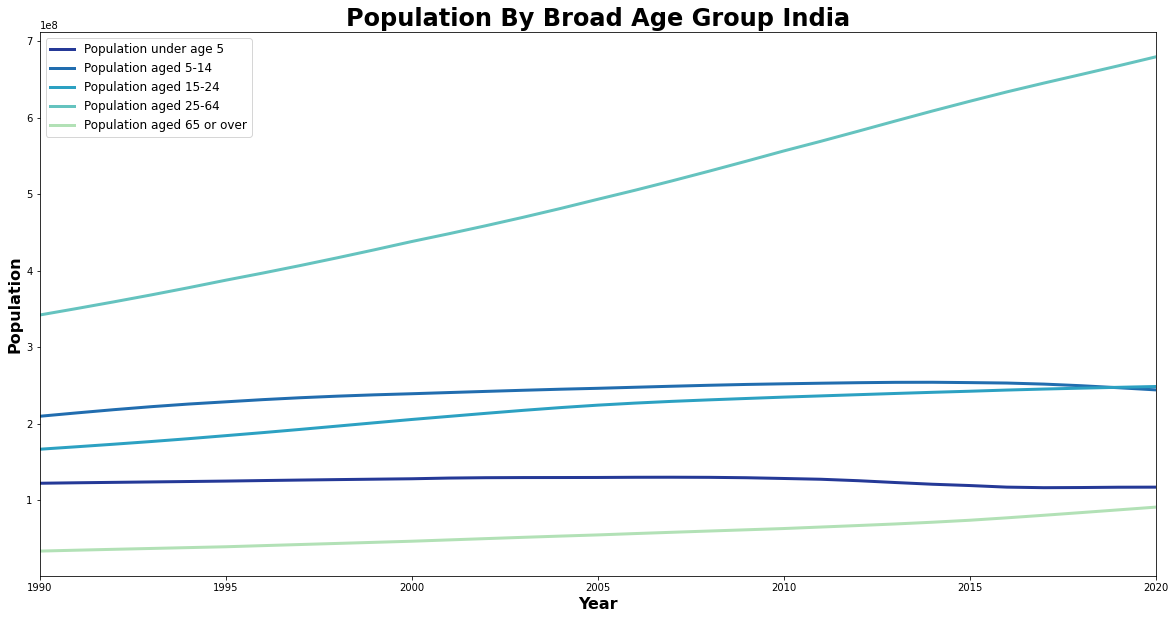

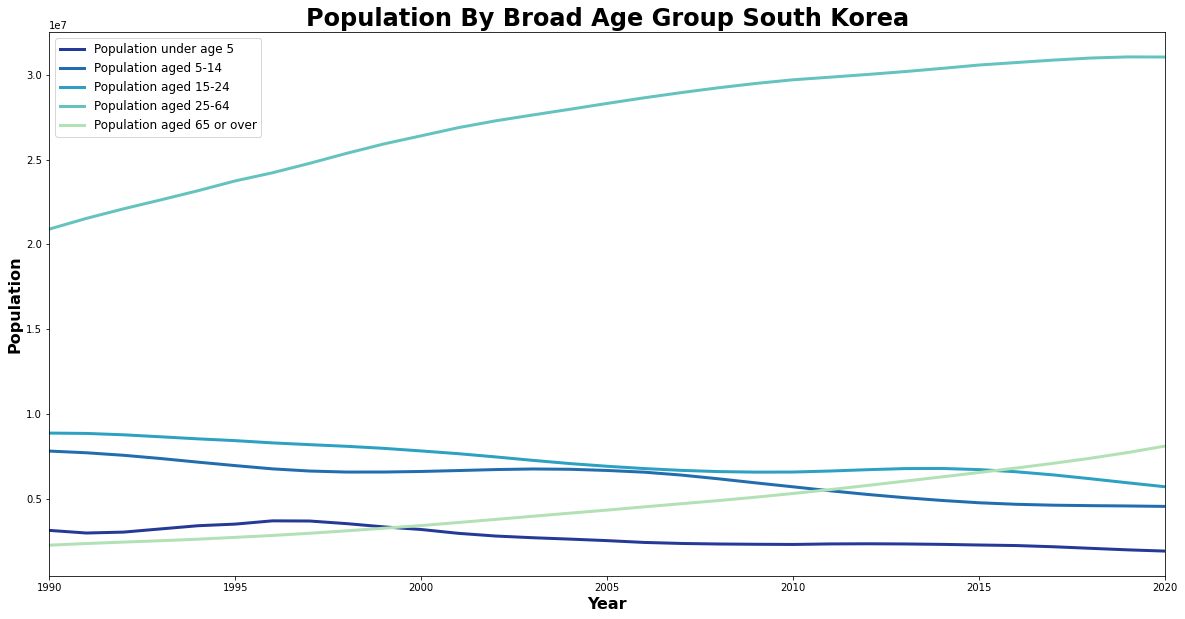

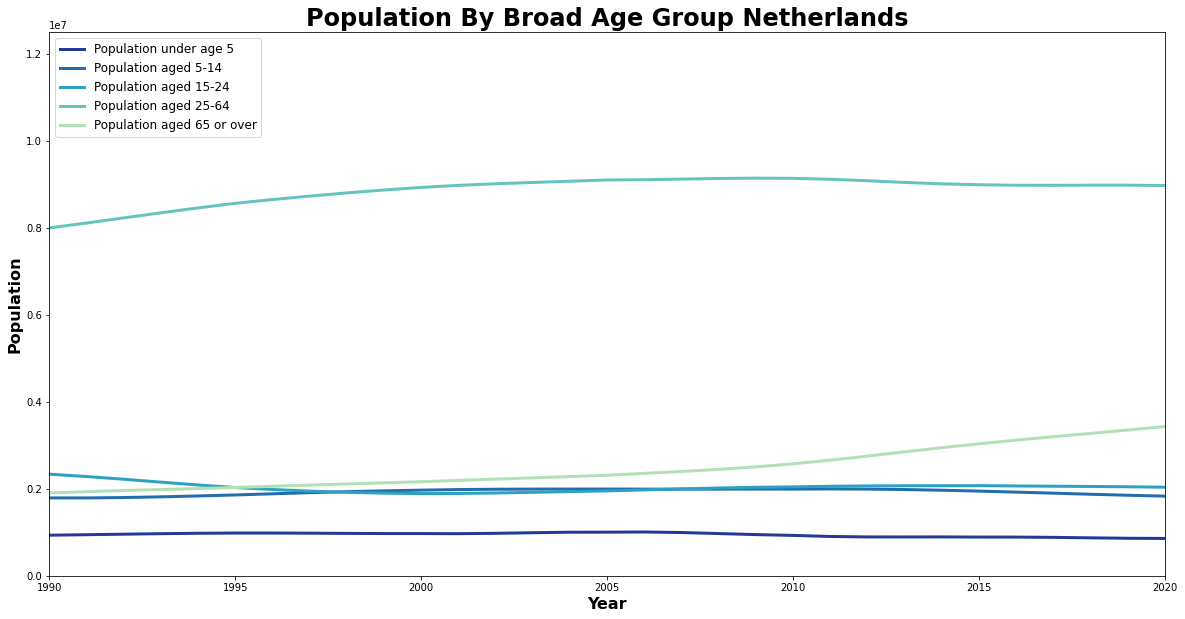

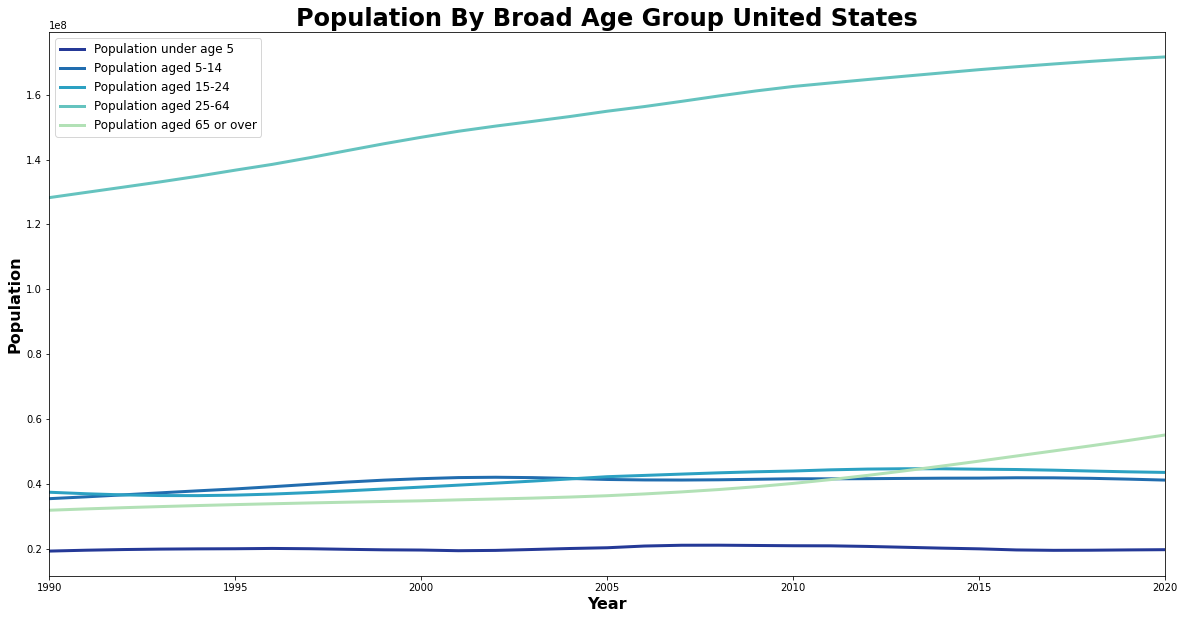

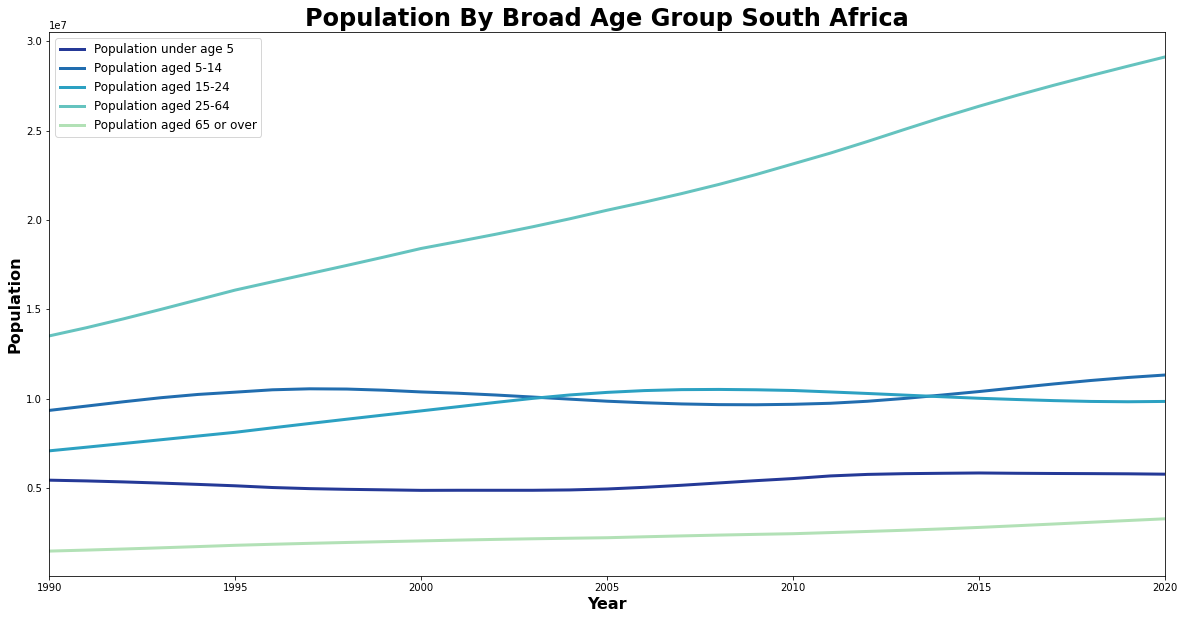

In [54]:
df_pop_per_age = df_pop_all[df_pop_all['Code'].isin(country_codes)].set_index('Entity').drop(columns=['Code'])
df_pop_per_age = df_pop_per_age[df_pop_per_age['Year'] > 1989]

pop_plot_esp = df_pop_per_age.loc['Spain'].set_index('Year').plot(figsize=(20, 10), color=colors, linewidth=3)
pop_plot_esp.set_title('Population By Broad Age Group Spain', fontsize=24, fontweight='bold')
pop_plot_esp.set_xlabel('Year', fontsize=16, fontweight='bold')
pop_plot_esp.set_ylabel('Population', fontsize=16, fontweight='bold')
pop_plot_esp.legend(loc=2, prop={'size':12})
pop_plot_esp.figure.savefig(f"{images_dir}/pop_spain.png", dpi=400, bbox_inches='tight')
pop_plot_esp.figure.savefig(f"{images_dir}/pop_esp.png", dpi=400, bbox_inches='tight')

pop_plot_ind = df_pop_per_age.loc['India'].set_index('Year').plot(figsize=(20, 10), color=colors, linewidth=3)
pop_plot_ind.set_title('Population By Broad Age Group India', fontsize=24, fontweight='bold')
pop_plot_ind.set_xlabel('Year', fontsize=16, fontweight='bold')
pop_plot_ind.set_ylabel('Population', fontsize=16, fontweight='bold')
pop_plot_ind.legend(loc=2, prop={'size':12})
pop_plot_ind.figure.savefig(f"{images_dir}/pop_ind.png", dpi=400, bbox_inches='tight')

pop_plot_kor = df_pop_per_age.loc['South Korea'].set_index('Year').plot(figsize=(20, 10), color=colors, linewidth=3)
pop_plot_kor.set_title('Population By Broad Age Group South Korea', fontsize=24, fontweight='bold')
pop_plot_kor.set_xlabel('Year', fontsize=16, fontweight='bold')
pop_plot_kor.set_ylabel('Population', fontsize=16, fontweight='bold')
pop_plot_kor.legend(loc=2, prop={'size':12})
pop_plot_kor.figure.savefig(f"{images_dir}/pop_kor.png", dpi=400, bbox_inches='tight')

pop_plot_nld = df_pop_per_age.loc['Netherlands'].set_index('Year').plot(figsize=(20, 10), color=colors, linewidth=3)
pop_plot_nld.set_title('Population By Broad Age Group Netherlands', fontsize=24, fontweight='bold')
pop_plot_nld.set_xlabel('Year', fontsize=16, fontweight='bold')
pop_plot_nld.set_ylabel('Population', fontsize=16, fontweight='bold')
pop_plot_nld.set_ylim([0, 12500000])
pop_plot_nld.legend(loc=2, prop={'size':12})
pop_plot_nld.figure.savefig(f"{images_dir}/pop_nld.png", dpi=400, bbox_inches='tight')

pop_plot_usa = df_pop_per_age.loc['United States'].set_index('Year').plot(figsize=(20, 10), color=colors, linewidth=3)
pop_plot_usa.set_title('Population By Broad Age Group United States', fontsize=24, fontweight='bold')
pop_plot_usa.set_xlabel('Year', fontsize=16, fontweight='bold')
pop_plot_usa.set_ylabel('Population', fontsize=16, fontweight='bold')
pop_plot_usa.legend(loc=2, prop={'size':12})
pop_plot_usa.figure.savefig(f"{images_dir}/pop_usa.png", dpi=400, bbox_inches='tight')

pop_plot_zaf = df_pop_per_age.loc['South Africa'].set_index('Year').plot(figsize=(20, 10), color=colors, linewidth=3)
pop_plot_zaf.set_title('Population By Broad Age Group South Africa', fontsize=24, fontweight='bold')
pop_plot_zaf.set_xlabel('Year', fontsize=16, fontweight='bold')
pop_plot_zaf.set_ylabel('Population', fontsize=16, fontweight='bold')
pop_plot_zaf.legend(loc=2, prop={'size':12})
pop_plot_zaf.figure.savefig(f"{images_dir}/pop_zaf.png", dpi=400, bbox_inches='tight')

In [55]:
df_religions = df_religions_per_pop[df_religions_per_pop['Year'].isin(['2010', '2020'])].drop(columns=['Region']).set_index(['Country', 'Year'])

df_religions_ind = df_religions.loc['India'].transpose()
df_religions_esp = df_religions.loc['Spain'].transpose()
df_religions_nld = df_religions.loc['Netherlands'].transpose()
df_religions_zaf = df_religions.loc['South Africa'].transpose()
df_religions_kor = df_religions.loc['South Korea'].transpose()
df_religions_usa = df_religions.loc['United States'].transpose()

labels = df_religions_ind.index

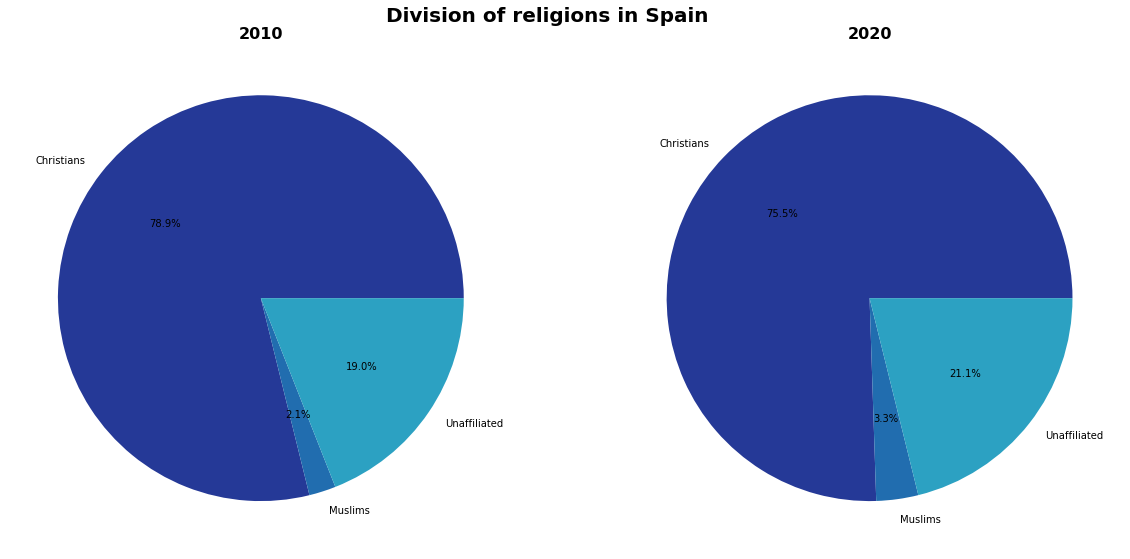

In [56]:
# Religions Spain
rel_pie_esp = plt.figure(figsize=(20,60))
rel_pie_esp.suptitle('Division of religions in Spain', fontsize = 20, fontweight='bold')
rel_pie_esp.subplots_adjust(top=1.70)

ax1 = rel_pie_esp.add_subplot(1,2,1)
ax2 = rel_pie_esp.add_subplot(1,2,2)

thresh_2010 = df_religions_esp['2010'].loc['All Religions'] * 0.01
df_2010 = df_religions_esp[df_religions_esp['2010'] > thresh_2010].drop(index=['All Religions'])
ax1.pie(df_2010['2010'], labels=df_2010.index.values, colors=colors, autopct='%1.1f%%')
ax1.set_title('2010', fontsize=16, fontweight='bold')
thresh_2020 = df_religions_esp['2020'].loc['All Religions'] * 0.01
df_2020 = df_religions_esp[df_religions_esp['2020'] > thresh_2020].drop(index=['All Religions'])
ax2.pie(df_2020['2020'], labels=df_2020.index.values, colors=colors, autopct='%1.1f%%')
ax2.set_title('2020', fontsize=16, fontweight='bold')

rel_pie_esp.savefig(f"{images_dir}/religions_spain.png", dpi=400, bbox_inches='tight')

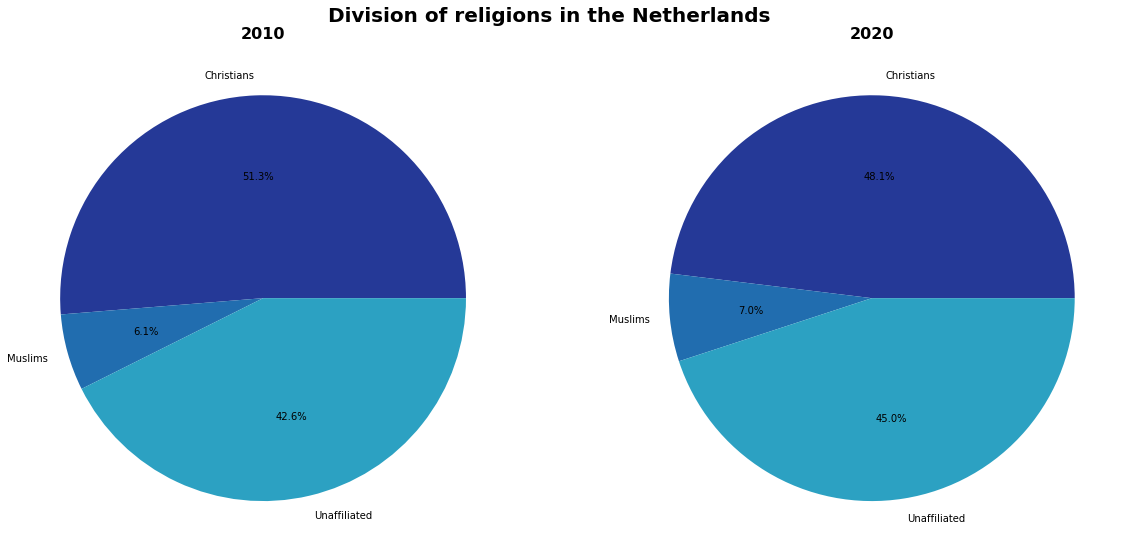

In [57]:
# Religions Netherlands
rel_pie_nld = plt.figure(figsize=(20,60))
rel_pie_nld.suptitle('Division of religions in the Netherlands', fontsize = 20, fontweight='bold')
rel_pie_nld.subplots_adjust(top=1.70)

ax1 = rel_pie_nld.add_subplot(1,2,1)
ax2 = rel_pie_nld.add_subplot(1,2,2)

thresh_2010 = df_religions_nld['2010'].loc['All Religions'] * 0.01
df_2010 = df_religions_nld[df_religions_nld['2010'] > thresh_2010].drop(index=['All Religions'])
ax1.pie(df_2010['2010'], labels=df_2010.index.values, colors=colors, autopct='%1.1f%%')
ax1.set_title('2010', fontsize=16, fontweight='bold')
thresh_2020 = df_religions_nld['2020'].loc['All Religions'] * 0.01
df_2020 = df_religions_nld[df_religions_nld['2020'] > thresh_2020].drop(index=['All Religions'])
ax2.pie(df_2020['2020'], labels=df_2020.index.values, colors=colors, autopct='%1.1f%%')
ax2.set_title('2020', fontsize=16, fontweight='bold')

rel_pie_nld.savefig(f"{images_dir}/religions_netherlands.png", dpi=400, bbox_inches='tight')

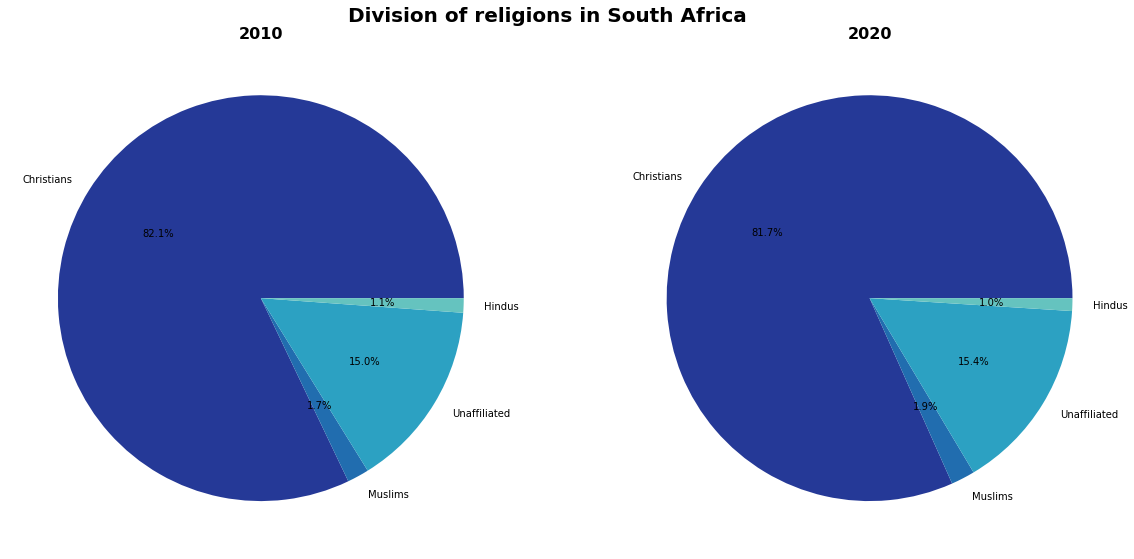

In [58]:
# Religions South Africa
rel_pie_zaf = plt.figure(figsize=(20,60))
rel_pie_zaf.suptitle('Division of religions in South Africa', fontsize = 20, fontweight='bold')
rel_pie_zaf.subplots_adjust(top=1.70)

ax1 = rel_pie_zaf.add_subplot(1,2,1)
ax2 = rel_pie_zaf.add_subplot(1,2,2)

thresh_2010 = df_religions_zaf['2010'].loc['All Religions'] * 0.01
df_2010 = df_religions_zaf[df_religions_zaf['2010'] > thresh_2010].drop(index=['All Religions'])
ax1.pie(df_2010['2010'], labels=df_2010.index.values, colors=colors, autopct='%1.1f%%')
ax1.set_title('2010', fontsize=16, fontweight='bold')
thresh_2020 = df_religions_zaf['2020'].loc['All Religions'] * 0.01
df_2020 = df_religions_zaf[df_religions_zaf['2020'] > thresh_2020].drop(index=['All Religions'])
ax2.pie(df_2020['2020'], labels=df_2020.index.values, colors=colors, autopct='%1.1f%%')
ax2.set_title('2020', fontsize=16, fontweight='bold')

rel_pie_zaf.savefig(f"{images_dir}/religions_zaf.png", dpi=400, bbox_inches='tight')

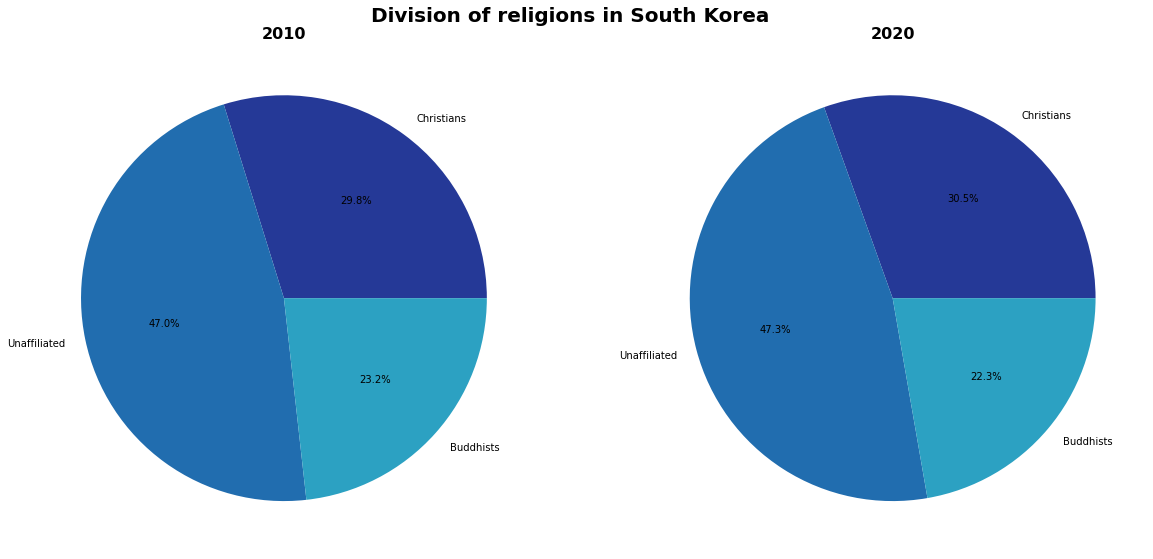

In [59]:
# Religions South Korea
rel_pie_kor = plt.figure(figsize=(20,60))
rel_pie_kor.suptitle('Division of religions in South Korea', fontsize = 20, fontweight='bold')
rel_pie_kor.subplots_adjust(top=1.70)

ax1 = rel_pie_kor.add_subplot(1,2,1)
ax2 = rel_pie_kor.add_subplot(1,2,2)

thresh_2010 = df_religions_kor['2010'].loc['All Religions'] * 0.01
df_2010 = df_religions_kor[df_religions_kor['2010'] > thresh_2010].drop(index=['All Religions'])
ax1.pie(df_2010['2010'], labels=df_2010.index.values, colors=colors, autopct='%1.1f%%')
ax1.set_title('2010', fontsize=16, fontweight='bold')
thresh_2020 = df_religions_kor['2020'].loc['All Religions'] * 0.01
df_2020 = df_religions_kor[df_religions_kor['2020'] > thresh_2020].drop(index=['All Religions'])
ax2.pie(df_2020['2020'], labels=df_2020.index.values, colors=colors, autopct='%1.1f%%')
ax2.set_title('2020', fontsize=16, fontweight='bold')

rel_pie_kor.savefig(f"{images_dir}/religions_kor.png", dpi=400, bbox_inches='tight')

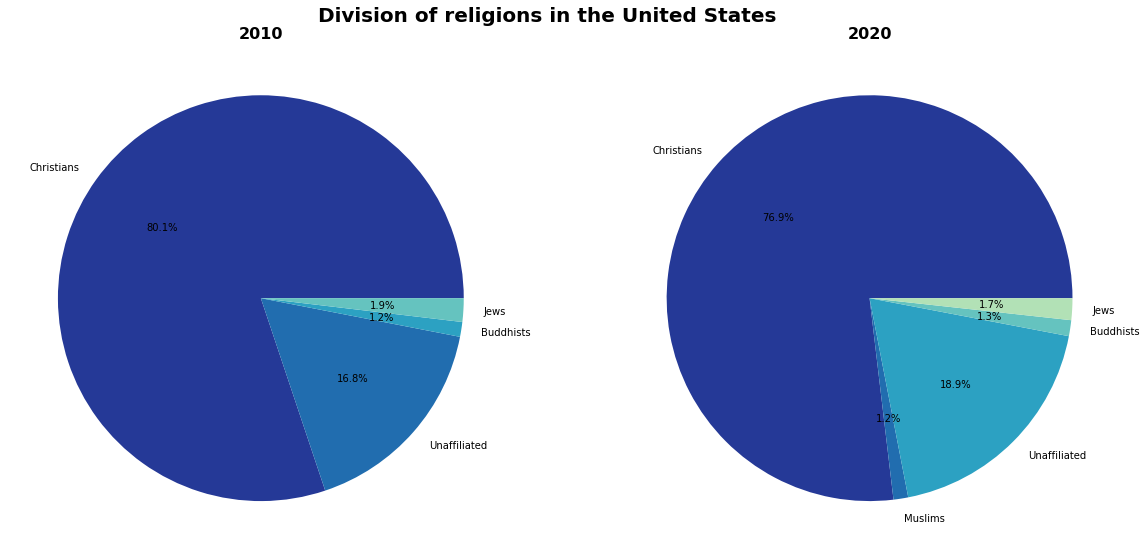

In [60]:
# Religions United States
rel_pie_usa = plt.figure(figsize=(20,60))
rel_pie_usa.suptitle('Division of religions in the United States', fontsize = 20, fontweight='bold')
rel_pie_usa.subplots_adjust(top=1.70)

ax1 = rel_pie_usa.add_subplot(1,2,1)
ax2 = rel_pie_usa.add_subplot(1,2,2)

thresh_2010 = df_religions_usa['2010'].loc['All Religions'] * 0.01
df_2010 = df_religions_usa[df_religions_usa['2010'] > thresh_2010].drop(index=['All Religions'])
ax1.pie(df_2010['2010'], labels=df_2010.index.values, colors=colors, autopct='%1.1f%%')
ax1.set_title('2010', fontsize=16, fontweight='bold')
thresh_2020 = df_religions_usa['2020'].loc['All Religions'] * 0.01
df_2020 = df_religions_usa[df_religions_usa['2020'] > thresh_2020].drop(index=['All Religions'])
ax2.pie(df_2020['2020'], labels=df_2020.index.values, colors=colors, autopct='%1.1f%%')
ax2.set_title('2020', fontsize=16, fontweight='bold')

rel_pie_usa.savefig(f"{images_dir}/religions_usa.png", dpi=400, bbox_inches='tight')

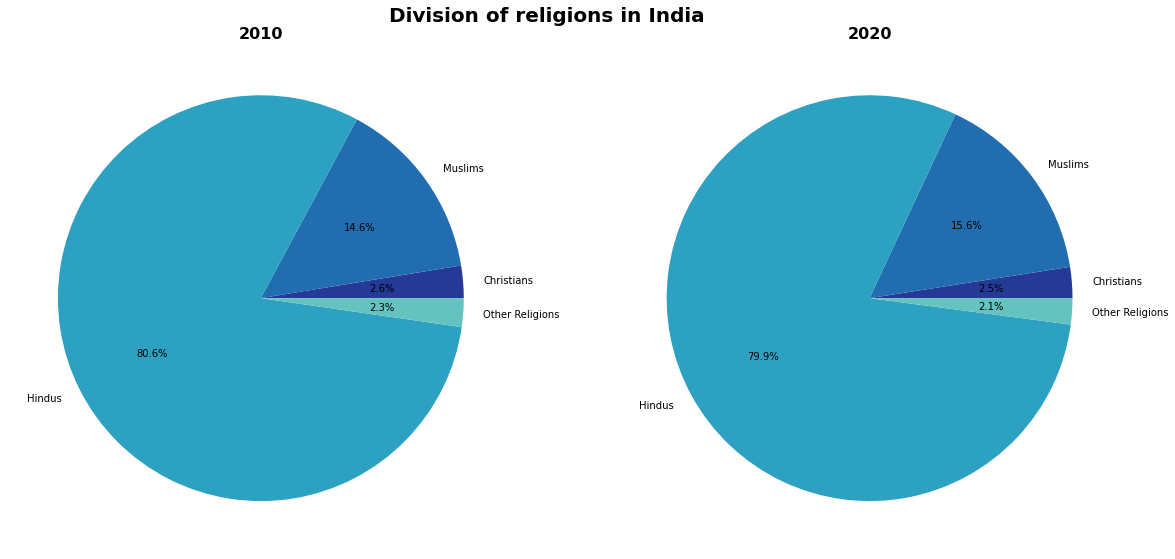

In [61]:
# Religions India
rel_pie_ind = plt.figure(figsize=(20,60))
rel_pie_ind.suptitle('Division of religions in India', fontsize = 20, fontweight='bold')
rel_pie_ind.subplots_adjust(top=1.70)

ax1 = rel_pie_ind.add_subplot(1,2,1)
ax2 = rel_pie_ind.add_subplot(1,2,2)

thresh_2010 = df_religions_ind['2010'].loc['All Religions'] * 0.01
df_2010 = df_religions_ind[df_religions_ind['2010'] > thresh_2010].drop(index=['All Religions'])
ax1.pie(df_2010['2010'], labels=df_2010.index.values, colors=colors, autopct='%1.1f%%')
ax1.set_title('2010', fontsize=16, fontweight='bold')
thresh_2020 = df_religions_ind['2020'].loc['All Religions'] * 0.01
df_2020 = df_religions_ind[df_religions_ind['2020'] > thresh_2020].drop(index=['All Religions'])
ax2.pie(df_2020['2020'], labels=df_2020.index.values, colors=colors, autopct='%1.1f%%')
ax2.set_title('2020', fontsize=16, fontweight='bold')

rel_pie_ind.savefig(f"{images_dir}/religions_india.png", dpi=400, bbox_inches='tight')

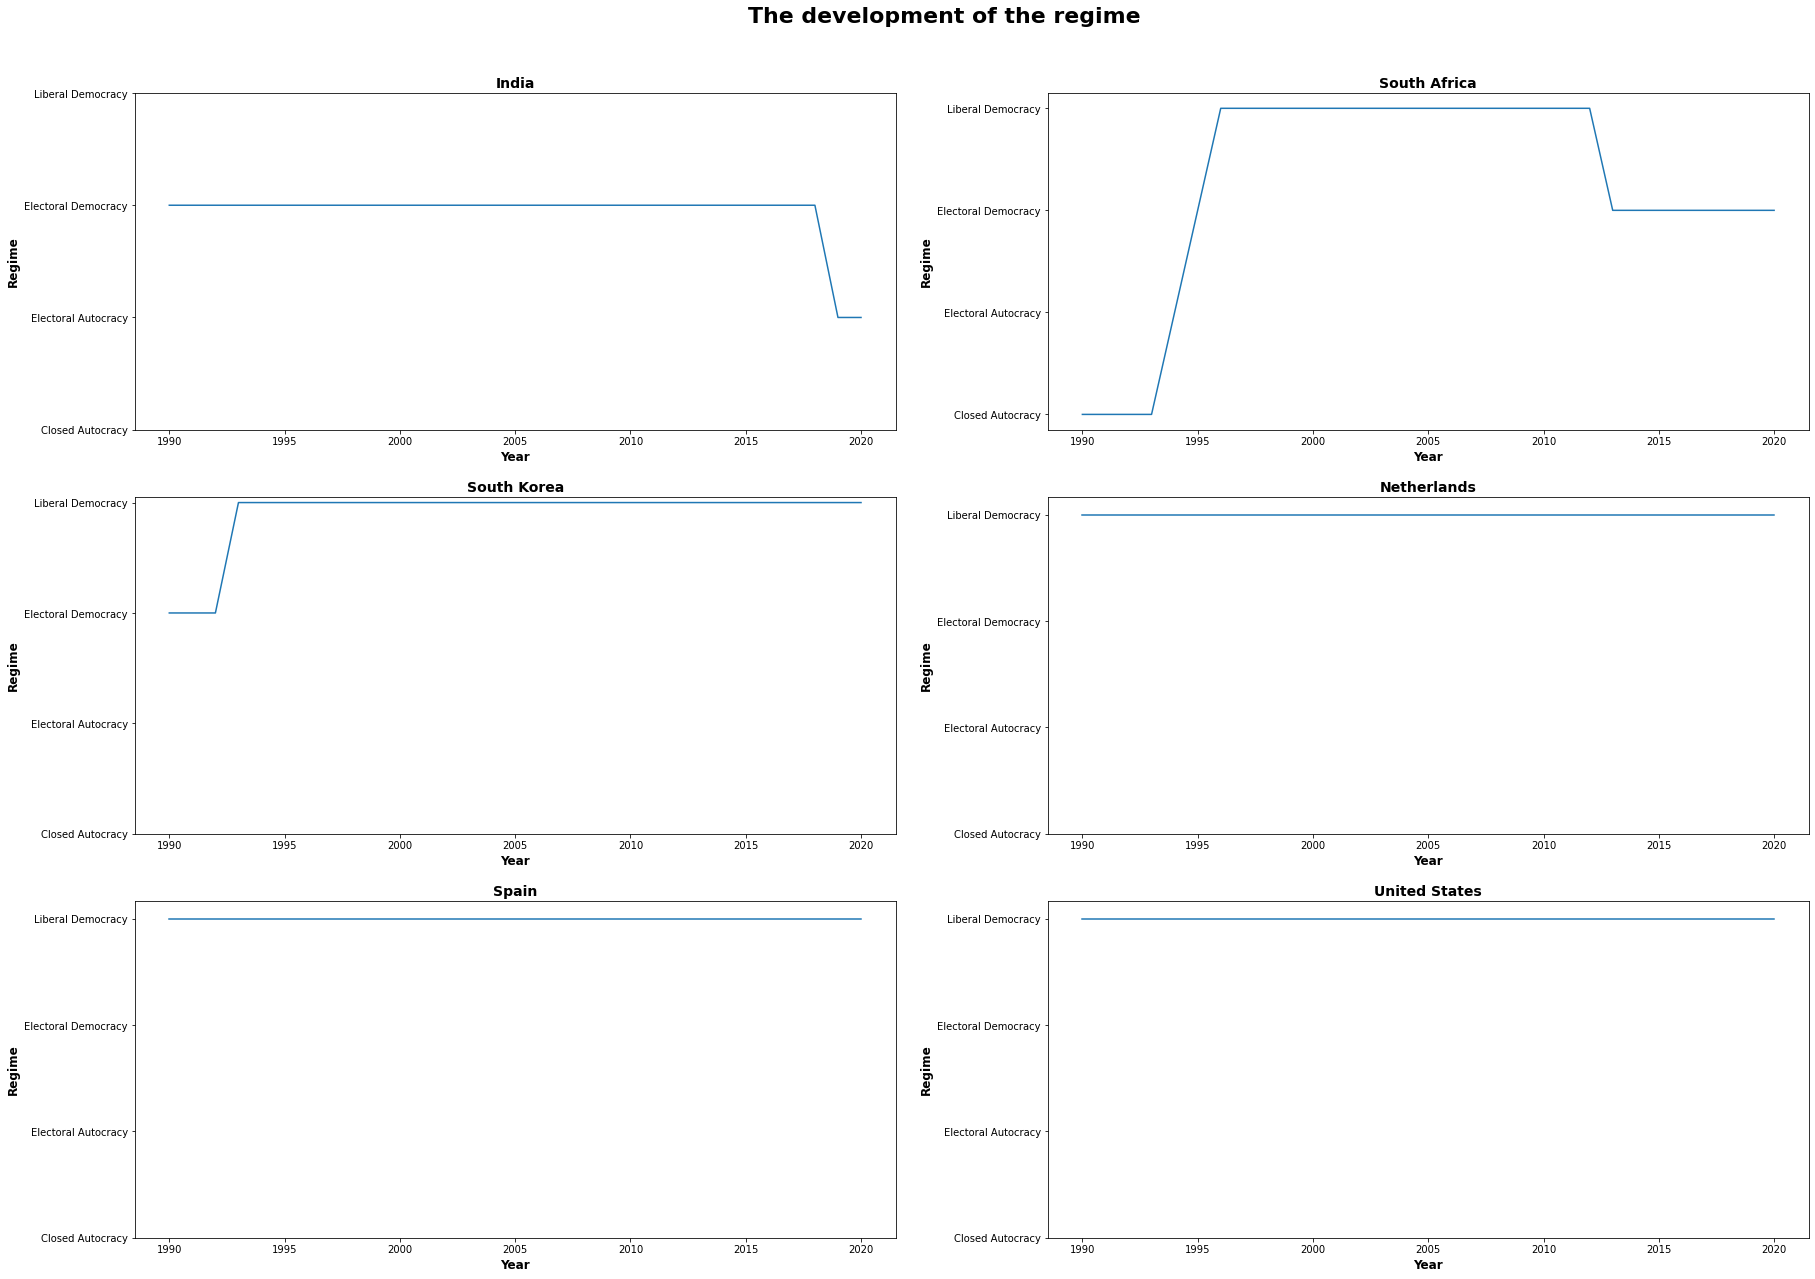

In [62]:
regime_types = {'Closed Autocracy':0, 'Electoral Autocracy':1, 'Electoral Democracy':2, 'Liberal Democracy':3}
df_regimes = df_political_regimes.drop(columns=['Code']).replace({'Political regime': regime_types}).rename(columns={'Entity':'Country'})
df_regimes = df_regimes.pivot(index='Year', columns='Country', values='Political regime').dropna(axis=0)
df_regimes = df_regimes.reset_index().loc[90:].astype({'Year':int}).set_index('Year')

regime_fig = plt.figure(figsize=(30,20))
regime_fig.suptitle('The development of the regime', fontsize = 22, fontweight='bold')
regime_fig.subplots_adjust(top=0.92)

ax1 = regime_fig.add_subplot(3,2,1)
ax1.plot(df_regimes['India'])
ax1.set_title('India', fontweight='bold', fontsize=14)
ax1.set_yticks([0,1,2,3])
ax1.set_yticklabels(['Closed Autocracy', 'Electoral Autocracy', 'Electoral Democracy', 'Liberal Democracy'])
ax1.set_ylabel('Regime', fontsize=12, fontweight='bold')
ax1.set_xlabel('Year', fontsize=12, fontweight='bold')

ax2 = regime_fig.add_subplot(3,2,2)
ax2.plot(df_regimes['South Africa'])
ax2.set_title('South Africa', fontweight='bold', fontsize=14)
ax2.set_yticks([0,1,2,3])
ax2.set_yticklabels(['Closed Autocracy', 'Electoral Autocracy', 'Electoral Democracy', 'Liberal Democracy'])
ax2.set_ylabel('Regime', fontsize=12, fontweight='bold')
ax2.set_xlabel('Year', fontsize=12, fontweight='bold')

ax3 = regime_fig.add_subplot(3,2,3)
ax3.plot(df_regimes['South Korea'])
ax3.set_title('South Korea', fontweight='bold', fontsize=14)
ax3.set_yticks([0,1,2,3])
ax3.set_yticklabels(['Closed Autocracy', 'Electoral Autocracy', 'Electoral Democracy', 'Liberal Democracy'])
ax3.set_ylabel('Regime', fontsize=12, fontweight='bold')
ax3.set_xlabel('Year', fontsize=12, fontweight='bold')

ax4 = regime_fig.add_subplot(3,2,4)
ax4.plot(df_regimes['Netherlands'])
ax4.set_title('Netherlands', fontweight='bold', fontsize=14)
ax4.set_yticks([0,1,2,3])
ax4.set_yticklabels(['Closed Autocracy', 'Electoral Autocracy', 'Electoral Democracy', 'Liberal Democracy'])
ax4.set_ylabel('Regime', fontsize=12, fontweight='bold')
ax4.set_xlabel('Year', fontsize=12, fontweight='bold')

ax5 = regime_fig.add_subplot(3,2,5)
ax5.plot(df_regimes['Spain'])
ax5.set_title('Spain', fontweight='bold', fontsize=14)
ax5.set_yticks([0,1,2,3])
ax5.set_yticklabels(['Closed Autocracy', 'Electoral Autocracy', 'Electoral Democracy', 'Liberal Democracy'])
ax5.set_ylabel('Regime', fontsize=12, fontweight='bold')
ax5.set_xlabel('Year', fontsize=12, fontweight='bold')

ax6 = regime_fig.add_subplot(3,2,6)
ax6.plot(df_regimes['United States'])
ax6.set_title('United States', fontweight='bold', fontsize=14)
ax6.set_yticks([0,1,2,3])
ax6.set_yticklabels(['Closed Autocracy', 'Electoral Autocracy', 'Electoral Democracy', 'Liberal Democracy'])
ax6.set_ylabel('Regime', fontsize=12, fontweight='bold')
ax6.set_xlabel('Year', fontsize=12, fontweight='bold')

regime_fig.savefig(f"{images_dir}/regime.png", dpi=400, bbox_inches='tight')

### Netflix Rank (~2021):

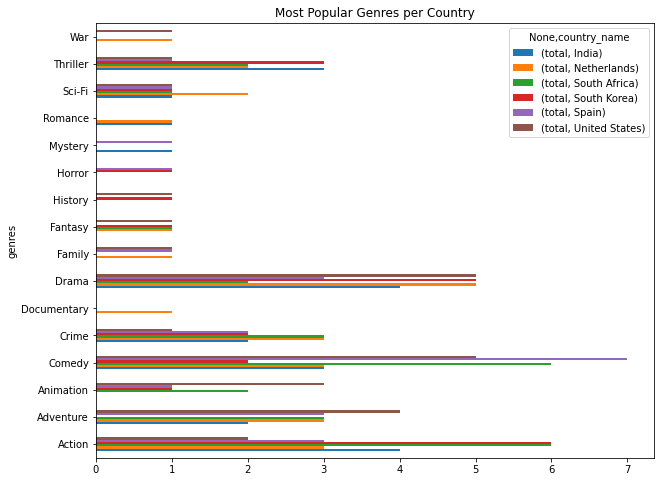

In [63]:
totalGenreCountry.unstack(level=0).plot(title='Most Popular Genres per Country' ,kind='barh', subplots=False, rot=0, figsize=(10, 8), layout=(6, 1))


/usr/local/lib/python3.7/dist-packages/pandas/plotting/_matplotlib/tools.py:307: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
/usr/local/lib/python3.7/dist-packages/pandas/plotting/_matplotlib/tools.py:307: MatplotlibDeprecationWarning: 
The colNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().colspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
/usr/local/lib/python3.7/dist-packages/pandas/plotting/_matplotlib/tools.py:313: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  if not layout[ax.rowNum + 1, ax.colNum]:
/usr/local/lib/python3.7/dist-packages/pandas/plotting/_matplotlib/tools.py:3

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f9fcf0be450>,
      dtype=object)

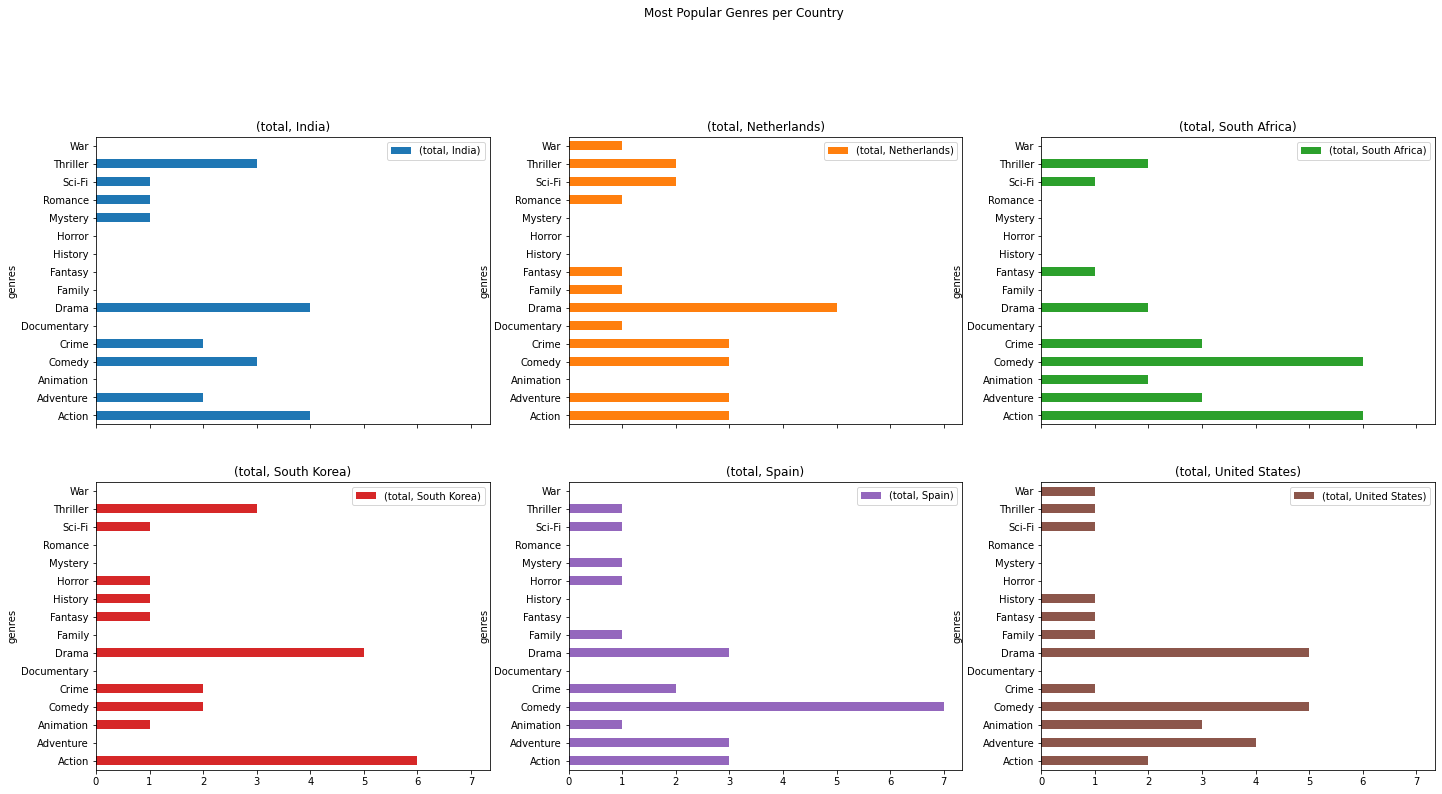

In [64]:
totalGenreCountry.unstack(level=0).plot(title='Most Popular Genres per Country' ,kind='barh', subplots=True, rot=0, figsize=(24, 18), layout=(3, 3))